# Проект: *Обучение с учителем: качество модели*
## Описание проекта

**Разработка модели для предказания покупательской активности и выдачи персонализированных предложений клиентам интернет-магазина**

**<u>Цели проекта:</u>**
1. Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. Используя данные модели, а также дополнительные данные финансового департамента о прибыльности клиентов, выделить сегмент покупателей и разработать для него персонализированные предложения.

**<u>План выполнения проекта:</u>**
1. Загрузить данные и проверить, что данные в таблицах соответствуют описанию.
2. Предобработать данные: проверить наличие пропусков, дубликатов, некорректных значений и обработать их.
3. Провести исследовательский анализ данных из каждой таблицы. Отобрать клиентов с покупательской активностью не менее трёх месяцев.
4. Объединить таблицы
5. Провести корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделать выводы о мультиколлинеарности и при необходимости устранить её.
6. Используя пайплайны, предсказать покупательскую активность. Будем решать задачу бинарной классификации (покупательская активность может снизиться или остаться прежней):
   - Для подготовки данных создать пайплайн с использованием ColumnTransformer.
   - Создать пайплайн для поиска лучшей модели из KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC. Для каждой модели подберем гиперпараметры.
   - Оценить качество модели, выбрав подходящую метрику. 
7. Проанализировать важность признаков с помощью метода SHAP. Сделать выводы о значимости признаков:
    - какие признаки мало значимы для модели;
    - какие признаки сильнее всего влияют на целевой признак;
    - как можно использовать эти наблюдения при моделировании и принятии бизнес-решений.
8. Выполнить сегментацию покупателей, используя результаты моделирования и данные о прибыльности покупателей. Выбрать группу покупателей и предложить, как увеличить её покупательскую активность, проведя графическое и аналитическое исследование.
9. Сделать общие выводы.

Ссылка на репозиторий проекта на GitHub: https://github.com/darianter/project

## 0. Загрузка библиотек

In [1]:
# контроль версий
!pip install -q numpy==1.22.4 pandas==1.5.1
!pip install -q -U scipy
!pip install -q matplotlib==3.5
!pip install -q -U seaborn
!pip install -q -U phik
!pip install -q -U shap
!pip install -q -U scikit-learn

In [2]:
# загрузка библиотек
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import shap
import seaborn as sns
import phik

## 1. Загрузка данных
### 1.1. Описание данных
Нам предоставлены 4 таблицы:
#### market_file.csv
Данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
- id — номер покупателя в корпоративной базе данных.
- Покупательская активность — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- Тип сервиса — уровень сервиса, например «премиум» и «стандарт».
- Разрешить сообщать — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- Маркет_актив_6_мес — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- Маркет_актив_тек_мес — количество маркетинговых коммуникаций в текущем месяце.
- Длительность — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- Акционные_покупки — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- Популярная_категория — самая популярная категория товаров у покупателя за последние 6 месяцев.
- Средний_просмотр_категорий_за_визит — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- Неоплаченные_продукты_штук_квартал — общее число неоплаченных товаров в корзине за последние 3 месяца.
- Ошибка_сервиса — число сбоев, которые коснулись покупателя во время посещения сайта.
- Страниц_за_визит — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

#### market_money.csv
Данные о выручке, которую получил магазин с покупателя за период его взаимодействия с сайтом.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- Выручка — сумма выручки за период.

#### market_time.csv
Данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
- id — номер покупателя в корпоративной базе данных.
- Период — название периода, во время которого зафиксировано общее время.
- минут — значение времени, проведённого на сайте, в минутах.

#### money.csv
Данные о среднемесячной прибыли от покупателя за последние 3 месяца.
- id — номер покупателя в корпоративной базе данных.
- Прибыль — значение прибыли.

### 1.2. Загрузка таблиц
Загрузим таблицы:

In [3]:
# загрузка таблиц
market_file = pd.read_csv('https://code.s3.yandex.net/datasets/market_file.csv')
market_money = pd.read_csv('https://code.s3.yandex.net/datasets/market_money.csv')
market_time = pd.read_csv('https://code.s3.yandex.net/datasets/market_time.csv')
money = pd.read_csv('https://code.s3.yandex.net/datasets/money.csv', sep=';', decimal=',')

Изучим данные и убедимся, что они соответствуют описанию:

In [4]:
# функция для вывода информации о данных
def df_info(df, df_name):
    # вывод информации о датасете
    print('\033[1m' + f'Информация о датафрейме {df_name}:' + '\033[0m')
    df.info()
    print("=" * 60)
    # вывод 5 первых строк из датасета
    print('\033[1m' + f'Первые строки датафрейма {df_name}:' + '\033[0m')
    return(df.head())

In [5]:
# знакомство с датасетом
df_info(market_file, 'market_file')

Информация о датафрейме market_file:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64 

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [6]:
# знакомство с датасетом
df_info(market_money, 'market_money')

Информация о датафрейме market_money:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB
Первые строки датафрейма market_money:


,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [7]:
# знакомство с датасетом
df_info(market_time, 'market_time')

Информация о датафрейме market_time:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB
Первые строки датафрейма market_time:


,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [8]:
# знакомство с датасетом
df_info(money, 'money')

Информация о датафрейме money:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB
Первые строки датафрейма money:


,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


Датасеты соответствуют описаниям, и в них указаны корректные типы данных.

## 2. Предобработка данных

### 2.1. Переименование столбцов
Названия столбцов не соотвествуют правилам оформления данных: в некоторых названиях есть пробелы, и все столбцы кроме id даны на кириллице. Переименуем столбцы:

In [9]:
# переименование столбцов
market_file = market_file.rename(columns={'Покупательская активность': 'buying_activity', 
                                          'Тип сервиса':'service_type',
                                          'Разрешить сообщать':'announcements',
                                          'Маркет_актив_6_мес':'marketing_mean',
                                          'Маркет_актив_тек_мес':'marketing_current',
                                          'Длительность':'duration',
                                          'Акционные_покупки':'promo_purchases',
                                          'Популярная_категория':'top_category',
                                          'Средний_просмотр_категорий_за_визит':'categories_per_visit',
                                          'Неоплаченные_продукты_штук_квартал':'unpaid_items',
                                          'Ошибка_сервиса':'errors',
                                          'Страниц_за_визит':'pages_per_visit'
                                         })

# вывод случайной строки измененного датафрейма
print('\033[1m' + "Столбцы в market_file переименованы:" + '\033[0m')
market_file.sample(1)

Столбцы в market_file переименованы:


,id,buying_activity,service_type,announcements,marketing_mean,marketing_current,duration,promo_purchases,top_category,categories_per_visit,unpaid_items,errors,pages_per_visit
120,215468,Снизилась,стандарт,да,2.7,4,515,0.94,Косметика и аксесуары,1,4,2,2


In [10]:
# переименование столбцов
market_money = market_money.rename(columns={'Период': 'period', 
                                           'Выручка':'revenue',
                                          })

# вывод случайной строки измененного датафрейма
print('\033[1m' + "Столбцы в market_money переименованы:" + '\033[0m')
market_money.sample(1)

Столбцы в market_money переименованы:


,id,period,revenue
661,215568,препредыдущий_месяц,4740.0


In [11]:
# переименование столбцов
market_time = market_time.rename(columns={'Период': 'period', 
                                          'минут':'minutes',
                                         })

# вывод случайной строки измененного датафрейма
print('\033[1m' + "Столбцы в market_time переименованы:" + '\033[0m')
market_time.sample(1)

Столбцы в market_time переименованы:


,id,period,minutes
156,215426,текущий_месяц,7


In [12]:
# переименование столбцов
money = money.rename(columns={'Прибыль': 'profit'})

# вывод случайной строки измененного датафрейма
print('\033[1m' + "Столбцы в money переименованы:" + '\033[0m')
money.sample(1)

Столбцы в money переименованы:


,id,profit
520,215868,5.58


### 2.2. Обновленное описание данных
#### market_file
- id — номер покупателя в корпоративной базе данных.
- buying_activity — рассчитанный класс покупательской активности (целевой признак): «снизилась» или «прежний уровень».
- service_type — уровень сервиса, например «премиум» и «стандарт».
- announcements — информация о том, можно ли присылать покупателю дополнительные предложения о товаре. Согласие на это даёт покупатель.
- marketing_mean — среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев. Это значение показывает, какое число рассылок, звонков, показов рекламы и прочего приходилось на клиента.
- marketing_current — количество маркетинговых коммуникаций в текущем месяце.
- duration — значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте.
- promo_purchases — среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.
- top_category — самая популярная категория товаров у покупателя за последние 6 месяцев.
- categories_per_visit — показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- unpaid_items — общее число неоплаченных товаров в корзине за последние 3 месяца.
- errors — число сбоев, которые коснулись покупателя во время посещения сайта.
- pages_per_visit — среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

#### market_money
- id — номер покупателя в корпоративной базе данных.
- period — название периода, во время которого зафиксирована выручка. Например, 'текущий_месяц' или 'предыдущий_месяц'.
- revenue — сумма выручки за период.

#### market_time
- id — номер покупателя в корпоративной базе данных.
- period — название периода, во время которого зафиксировано общее время.
- minutes — значение времени, проведённого на сайте, в минутах.

#### money
- id — номер покупателя в корпоративной базе данных.
- profit — значение прибыли.

### 2.3. Полные дубликаты
Проверим наличие полных дубликатов:

In [13]:
# функция для подсчета дубликатов
def count_duplicates(df, df_name):
    print(50*'-')
    print(f'Количество полных дубликатов в датафрейме {df_name}:', df.duplicated().sum())
    print(50*'-')

In [14]:
# вызов функции для подсчета дубликатов для всех датафреймов
count_duplicates(market_file, 'market_file')
count_duplicates(market_money, 'market_money')
count_duplicates(market_time, 'market_time')
count_duplicates(money, 'money')

--------------------------------------------------
Количество полных дубликатов в датафрейме market_file: 0
--------------------------------------------------
--------------------------------------------------
Количество полных дубликатов в датафрейме market_money: 0
--------------------------------------------------
--------------------------------------------------
Количество полных дубликатов в датафрейме market_time: 0
--------------------------------------------------
--------------------------------------------------
Количество полных дубликатов в датафрейме money: 0
--------------------------------------------------


В данных не обнаружилось полных дубликатов.

### 2.4. Пропущенные значения
Убедимся, что в данных нет пропусков:

In [15]:
# функция для подсчета пропусков
def count_na(df, df_name):
    print(50*'-')
    print(f'Количество пропусков в датафрейме {df_name}:')
    print(df.isna().sum())
    print(50*'-')

In [16]:
# вызов функции для подсчета пропусков для всех датафреймов
count_na(market_file, 'market_file')
count_na(market_money, 'market_money')
count_na(market_time, 'market_time')
count_na(money, 'money')

--------------------------------------------------
Количество пропусков в датафрейме market_file:
id                      0
buying_activity         0
service_type            0
announcements           0
marketing_mean          0
marketing_current       0
duration                0
promo_purchases         0
top_category            0
categories_per_visit    0
unpaid_items            0
errors                  0
pages_per_visit         0
dtype: int64
--------------------------------------------------
--------------------------------------------------
Количество пропусков в датафрейме market_money:
id         0
period     0
revenue    0
dtype: int64
--------------------------------------------------
--------------------------------------------------
Количество пропусков в датафрейме market_time:
id         0
period     0
minutes    0
dtype: int64
--------------------------------------------------
--------------------------------------------------
Количество пропусков в датафрейме money:
id   

В данных не обнаружилось пропусков.

### 2.5. Неявные дубликаты и нетипичные обозначения пропусков
Проверим наличие в данных неявных дубликатов и нетипичных обозначений пропусков, выведя все уникальные значения в столбцах.

In [17]:
# функция для вывода уникальных значений во всех столбцах датафрейма
def unique_values(df, df_name):
    print('\033[1m' + f'Уникальные значения столбцов в датафрейме {df_name}:' + '\033[1m')
    unique_values = {}
    for col in df.columns:
        unique_values[col] = df[col].sort_values().unique()
    return unique_values

In [18]:
# вывод уникальных значений
unique_values(market_file, 'market_file')

Уникальные значения столбцов в датафрейме market_file:


{'id': array([215348, 215349, 215350, ..., 216645, 216646, 216647], dtype=int64),
 'buying_activity': array(['Прежний уровень', 'Снизилась'], dtype=object),
 'service_type': array(['премиум', 'стандарт', 'стандартт'], dtype=object),
 'announcements': array(['да', 'нет'], dtype=object),
 'marketing_mean': array([0.9, 1.4, 1.5, 1.7, 2.4, 2.6, 2.7, 2.9, 3. , 3.1, 3.2, 3.3, 3.4,
        3.5, 3.6, 3.7, 3.8, 3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7,
        4.8, 4.9, 5. , 5.1, 5.2, 5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6.1,
        6.3, 6.6]),
 'marketing_current': array([3, 4, 5], dtype=int64),
 'duration': array([ 110,  121,  125,  129,  131,  132,  133,  134,  135,  136,  140,
         142,  145,  147,  148,  149,  150,  151,  152,  153,  154,  157,
         159,  160,  161,  162,  163,  165,  166,  167,  168,  169,  170,
         171,  175,  176,  177,  179,  180,  181,  182,  184,  185,  186,
         187,  188,  190,  191,  192,  196,  199,  201,  202,  203,  205,
         206,  207,  

В датафрейме **market_time** не обнаружилось нетипично обозначенных пропусков. Однако в нем есть неявные дубликаты в столбце service_type. Исправим это:

In [19]:
# удаление неявного дубликата
market_file['service_type'] = market_file['service_type'].replace('стандартт', 'стандарт')
print('Неявные дубликаты удалены. Уникальные значения в столбце service_type:')
market_file['service_type'].unique().tolist()

Неявные дубликаты удалены. Уникальные значения в столбце service_type:


['премиум', 'стандарт']

In [20]:
# вывод уникальных значений
unique_values(market_money, 'market_money')

Уникальные значения столбцов в датафрейме market_money:


{'id': array([215348, 215349, 215350, ..., 216645, 216646, 216647], dtype=int64),
 'period': array(['предыдущий_месяц', 'препредыдущий_месяц', 'текущий_месяц'],
       dtype=object),
 'revenue': array([     0. ,   2758.7,   2890. , ...,   7605.3,   7799.4, 106862.2])}

В датафрейме **market_money** не обнаружилось нетипично обозначенных пропусков. Проверим, является ли 'препредыдущий_месяц' неявным дубликатом или названием категории:

In [21]:
print(f'В market_money {market_money.shape[0]} строк')
print('Количество наблюдений по категориям в столбце period:')
market_money.pivot_table(index='period', values='revenue', aggfunc='count')

В market_money 3900 строк
Количество наблюдений по категориям в столбце period:


,revenue
period,
предыдущий_месяц,1300
препредыдущий_месяц,1300
текущий_месяц,1300


'препредыдущий_месяц' - это полноценная категория.

In [22]:
# вывод уникальных значений
unique_values(market_time, 'market_time')

Уникальные значения столбцов в датафрейме market_time:


{'id': array([215348, 215349, 215350, ..., 216645, 216646, 216647], dtype=int64),
 'period': array(['предыдцщий_месяц', 'текущий_месяц'], dtype=object),
 'minutes': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
        21, 22, 23], dtype=int64)}

В датафрейме **market_time** не обнаружилось нетипично обозначенных пропусков и неявных дубликатов, но обнаружилась опечатка в категории столбца period. Исправим ее:

In [23]:
# перекодирование столбца
market_time['period'] = market_time['period'].replace('предыдцщий_месяц', 'предыдущий_месяц')
print('Уникальные значения в столбце period:')
market_time['period'].unique().tolist()

Уникальные значения в столбце period:


['текущий_месяц', 'предыдущий_месяц']

In [24]:
# вывод уникальных значений
unique_values(money, 'money')

Уникальные значения столбцов в датафрейме money:


{'id': array([215348, 215349, 215350, ..., 216645, 216646, 216647], dtype=int64),
 'profit': array([0.86, 0.98, 1.06, 1.08, 1.33, 1.37, 1.38, 1.39, 1.4 , 1.48, 1.54,
        1.55, 1.57, 1.63, 1.64, 1.68, 1.81, 1.82, 1.83, 1.84, 1.87, 1.92,
        1.95, 1.97, 2.  , 2.02, 2.03, 2.07, 2.08, 2.09, 2.1 , 2.11, 2.13,
        2.15, 2.16, 2.18, 2.19, 2.21, 2.23, 2.24, 2.26, 2.27, 2.29, 2.32,
        2.33, 2.34, 2.35, 2.36, 2.37, 2.38, 2.39, 2.41, 2.42, 2.43, 2.44,
        2.45, 2.46, 2.47, 2.48, 2.49, 2.5 , 2.51, 2.53, 2.54, 2.55, 2.57,
        2.59, 2.6 , 2.61, 2.63, 2.64, 2.66, 2.67, 2.68, 2.69, 2.7 , 2.71,
        2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79, 2.8 , 2.81, 2.82,
        2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.9 , 2.91, 2.92, 2.93, 2.94,
        2.95, 2.96, 2.97, 2.98, 2.99, 3.  , 3.01, 3.03, 3.04, 3.05, 3.06,
        3.07, 3.08, 3.09, 3.1 , 3.11, 3.12, 3.13, 3.14, 3.15, 3.16, 3.17,
        3.18, 3.19, 3.2 , 3.21, 3.22, 3.23, 3.24, 3.25, 3.26, 3.27, 3.28,
        3.29, 3.3 , 

В датафрейме **money** не обнаружилось нетипичных обозначений пропусков.

Наконец, убедимся, что во всех датафреймах одному id всегда соответствует корректное количество строк:

In [25]:
# функция для проверки строк, соответсвующих id
def check_rows(df, ref_column):
    return(pd.DataFrame(df.groupby('id')[ref_column].count())[ref_column].unique().tolist())

In [26]:
for df in [market_file, market_money, market_time, money]:
    print(check_rows(df, df.columns[0]))

[1]
[3]
[2]
[1]


В market_file и в money каждому клиенту соответствует одна строка, в market_money для каждого клиента доступны данные за 3 периода, представленные тремя отдельными строками, в market_time аналогично представлены данные по двум периодам. Все корректно, исключений нет.

## 3. Исследовательский анализ данных

Проведем исследовательский анализ данных для каждой таблицы отдельно. Для количественных признаком построим диаграммы размаха и гистограммы, а также рассмотрим описательные статистики. Для категориальных признаков выведем круговые диаграммы.

### 3.1. Необходимые функции

Подготовим необходимые функции -- для выделения количественных и категориальных признаков, а также для построения графиков по каждому признаку.

In [27]:
# функция для выделения признаков
def features(df):
    return df.columns.tolist()

In [28]:
# функция для выделения количественных признаков 
def num_features(df):
    features = df.columns.tolist()
    return df[features].select_dtypes(include=['int64', 'float64']).columns.tolist()

In [29]:
# функция для выделения категориальных признаков 
def cat_features(df):
    features = df.columns.tolist()
    return df[features].select_dtypes(include=['object', 'category']).columns.tolist()

In [30]:
# функция для вывода графиков и описательных статистик
def boxplot_histogram(df, col):
    print(90*'-')

    # если признак континуальный, строим оба графика, если нет -- только график частот
    if len(df[col].unique()) >= 25:
        # определение межквартильного размаха
        q1 = np.percentile(df[col], 25)
        q3 = np.percentile(df[col], 75)
        iqr = q3 - q1

        # определение границ выбросов
        thresholds = (q1-3*iqr, q3+3*iqr)
        if thresholds[0] >=0:
            print('\x1b[1;31m---\x1b[0m', '\033[1mГраницы выбросов:\033[0m', f'({thresholds[0].round(3)}, {thresholds[1].round(3)})')
        else:
            print('\x1b[1;31m---\x1b[0m', '\033[1mГраница выбросов\033[0m', f'{thresholds[1].round(3)}')
            
        # задаем сетку с графиками
        fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [3, 1]})
        fig.suptitle(f'Распределение признака {col}')

        # расчет количества корзин
        bins_num = len(np.histogram_bin_edges(df[col], bins='fd')) - 1

        # гистограмма
        axes[0].hist(df[col], bins=bins_num, color='skyblue', edgecolor='black', alpha=0.7)
        axes[0].axvline(x=df[col].mean(), color='red', label='Среднее')
        axes[0].axvline(x=df[col].median(), color='blue', linestyle='--', label='Медиана')
        axes[0].grid(True, linestyle='--', alpha=0.5)
        axes[0].legend()

        # диаграмма размаха
        axes[1].boxplot(df[col], vert=True)
        axes[1].set_xticks([])
        axes[1].set_xticklabels([])
        axes[1].grid(True, linestyle='--', alpha=0.5)
        axes[1].axhline(y=thresholds[1], color="red", linestyle='--')
        if thresholds[0] >=0:
            axes[1].axhline(y=thresholds[0], color="red", linestyle='--')

        # отображение графиков
        plt.tight_layout()
        plt.show()

        # описательные статистики
        print('\033[1m' + f'Описательные статистики для признака {col}:' + '\033[0m')
        print(df[col].describe().round(3))

        print(90*'-')
    else:
        plt.figure(figsize=(10,5))
        sns.countplot(df, x=col, color='skyblue', edgecolor='black', alpha=0.7)
        plt.title(f'Распределение признака {col}')
        plt.show()
        
        # описательные статистики
        print('\033[1m' + f'Описательные статистики для признака {col}:' + '\033[0m')
        print(df[col].describe().round(3))

        print(90*'-')

In [31]:
# функция для вывода круговой диаграммы 
def piechart(df, col):
    print(90*'-')
    category_counts = df[col].value_counts()
    plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=90)
    plt.title(f'Круговая диаграмма для признака {col}')
    plt.text(-1.5, 1, f'Процент от {len(df)}', fontsize=9, color='black', 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
    plt.show()
    print(90*'-')

### 3.2. Датафрейм market_file
#### Количественные признаки

Сделаем id индексом:

In [32]:
market_file = market_file.set_index('id')

------------------------------------------------------------------------------------------
--- Границы выбросов: (0.1, 8.5)


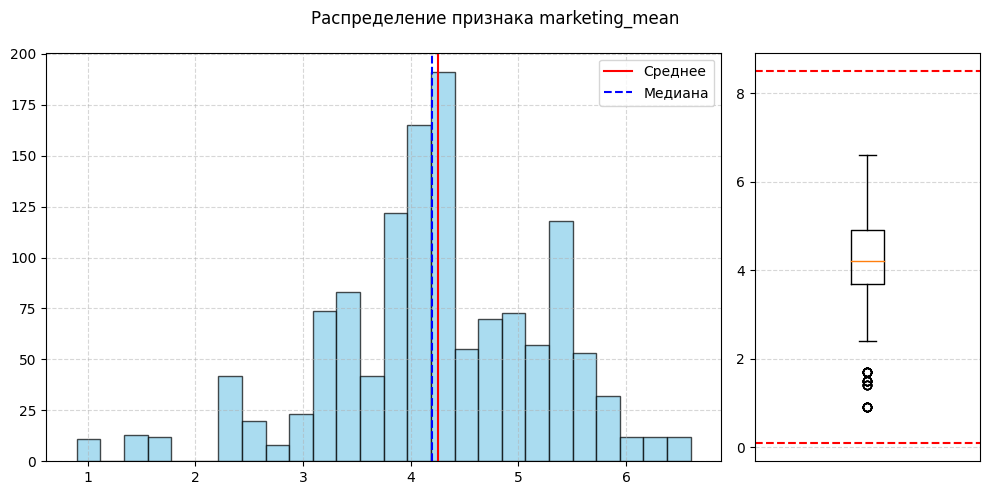

Описательные статистики для признака marketing_mean:
count    1300.000
mean        4.254
std         1.015
min         0.900
25%         3.700
50%         4.200
75%         4.900
max         6.600
Name: marketing_mean, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


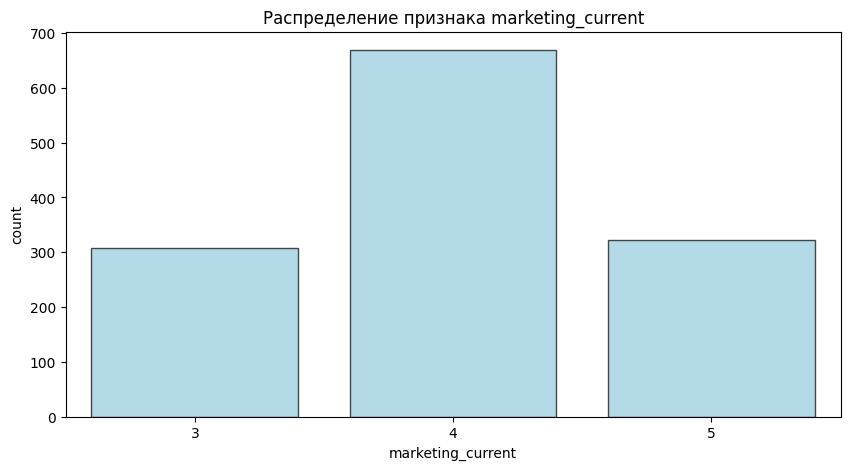

Описательные статистики для признака marketing_current:
count    1300.000
mean        4.012
std         0.697
min         3.000
25%         4.000
50%         4.000
75%         4.000
max         5.000
Name: marketing_current, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
--- Граница выбросов 2007.5


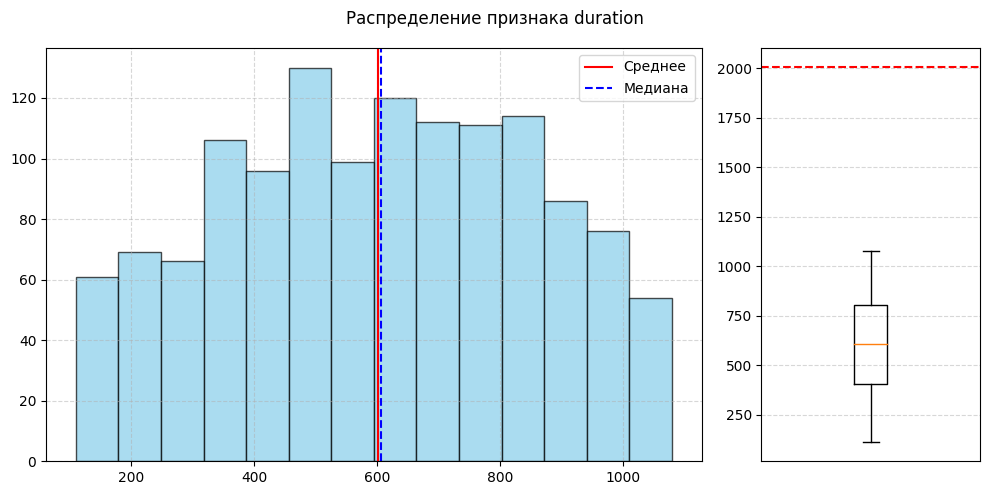

Описательные статистики для признака duration:
count    1300.000
mean      601.898
std       249.856
min       110.000
25%       405.500
50%       606.000
75%       806.000
max      1079.000
Name: duration, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
--- Граница выбросов 0.69


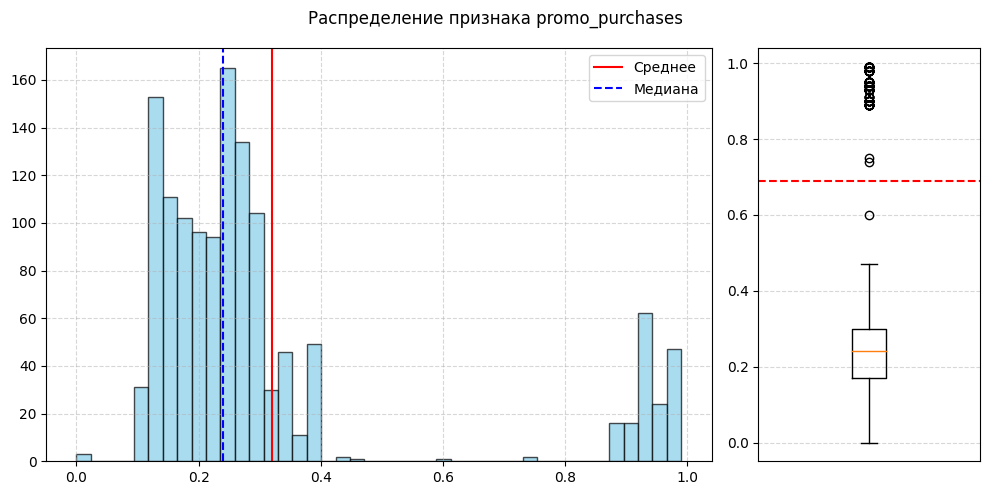

Описательные статистики для признака promo_purchases:
count    1300.00
mean        0.32
std         0.25
min         0.00
25%         0.17
50%         0.24
75%         0.30
max         0.99
Name: promo_purchases, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


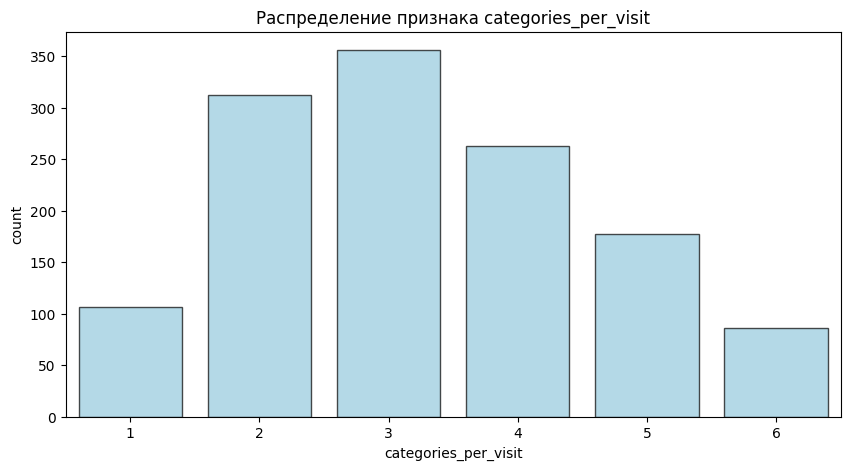

Описательные статистики для признака categories_per_visit:
count    1300.000
mean        3.270
std         1.355
min         1.000
25%         2.000
50%         3.000
75%         4.000
max         6.000
Name: categories_per_visit, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


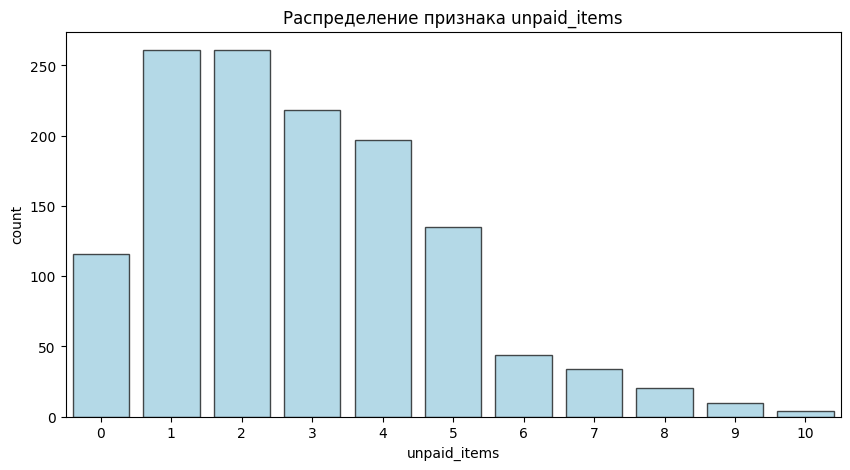

Описательные статистики для признака unpaid_items:
count    1300.000
mean        2.840
std         1.971
min         0.000
25%         1.000
50%         3.000
75%         4.000
max        10.000
Name: unpaid_items, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


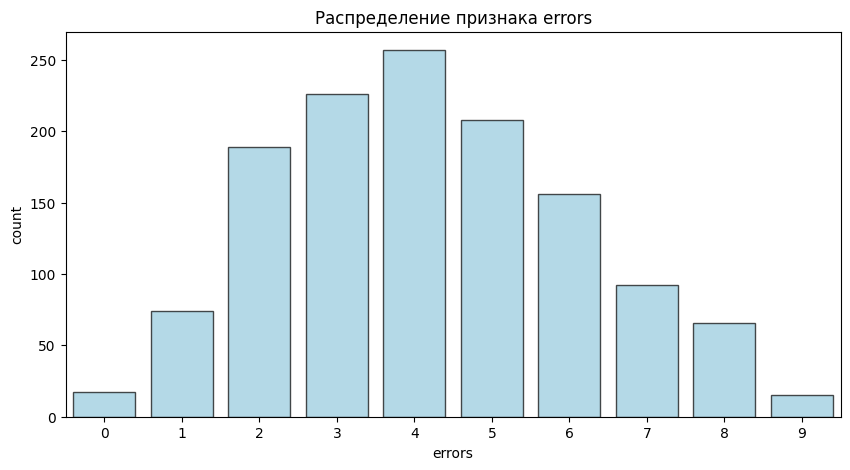

Описательные статистики для признака errors:
count    1300.000
mean        4.185
std         1.955
min         0.000
25%         3.000
50%         4.000
75%         6.000
max         9.000
Name: errors, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


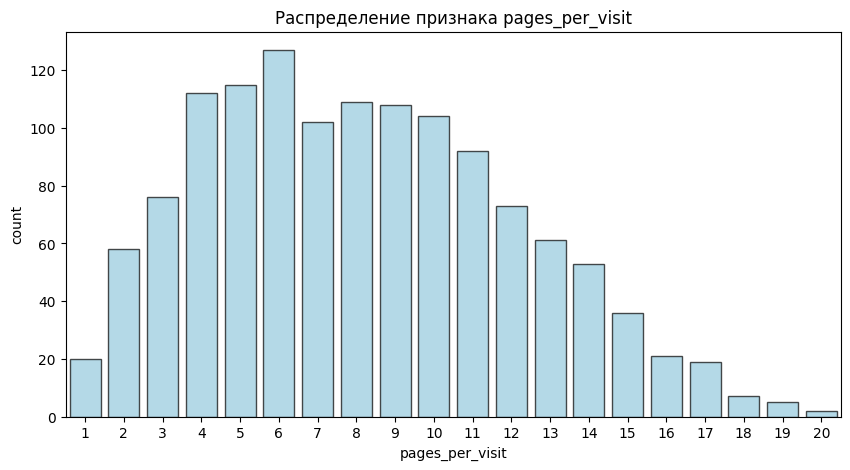

Описательные статистики для признака pages_per_visit:
count    1300.000
mean        8.177
std         3.978
min         1.000
25%         5.000
50%         8.000
75%        11.000
max        20.000
Name: pages_per_visit, dtype: float64
------------------------------------------------------------------------------------------


In [33]:
# вывод графиков и описательных статистик для всех количественных признаков
for col in num_features(market_file):
    boxplot_histogram(market_file, col)

- Распределение marketing_mean (среднемесячное число маркетинговых коммуникаций за 6 месяцев) близко к нормальному, но имеет несколько выбивающихся низких значений. При этом существенных выборосов (больше 3 межквартильных размахов) не обнаружено.
- В признаке marketing_current (количество маркетинговых коммуникаций в текущем месяце) наиболее частотное значение -- 4; 3 и 5 встречаются реже.
- Распределение признака duration (количество дней с момента регистрации) нормальное, выбросов не обнаружено.
- Распределение признака promo_purchases (среднемесячная доля покупок по акции за 6 месяцев) не нормальное. Можно заметить в данных 2 кластера: большинство наблюдений лежат в промежутке 0.15-0.4, но также встречается небольшая группа наблюдений в промежутке 0.8-1. То есть, для большинства клиентов акционные покупки составляют меньше половины от всех покупок, но у небольшой группы клиентов почти все покупки акционные.
- Распределение признака categories_per_visit близко к нормальному, но несколько скошено вправо.
- Распределение признака unpaid_items сильно скошено вправо.
- Признак errors распределен нормально.
- Распределение признака pages_for_visit скошено вправо.

In [34]:
# доля выбросов
outlier_prop= round(len(market_file[market_file['promo_purchases'] > 0.69])/len(market_file), 2)
print(f'Выбросы в promo_purchases составляют {outlier_prop:.0%} от всех значений')

Выбросы в promo_purchases составляют 13% от всех значений


Выбросы в promo_purchases составляют существенную долю от всех значений. Поскольку это не аномальные значения, которые потенциально важны, стоит их сохранить и попробовать преобразовать признак в категориальный (маленькая доля акционных покупок vs. большая доля акционных покупок с границей 0.69 (граница выбросов)).

In [35]:
# создание нового признака
market_file.loc[market_file['promo_purchases'] > 0.69, 'promo_purchases_cat'] = 'много'
market_file.loc[market_file['promo_purchases'] <= 0.69, 'promo_purchases_cat'] = 'мало'
market_file.head()

,buying_activity,service_type,announcements,marketing_mean,marketing_current,duration,promo_purchases,top_category,categories_per_visit,unpaid_items,errors,pages_per_visit,promo_purchases_cat
id,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,мало
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,много
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,мало
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,много
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,много


Признак добавился корректно.

#### Категориальные признаки

------------------------------------------------------------------------------------------


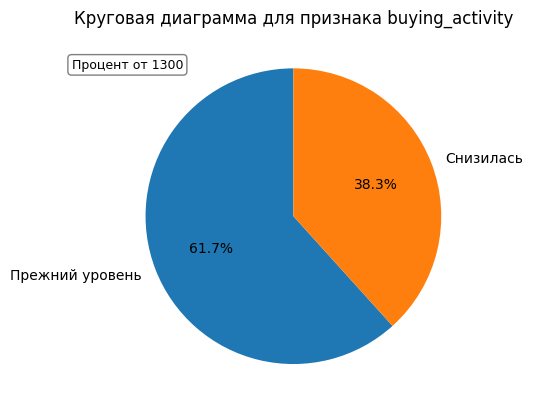

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


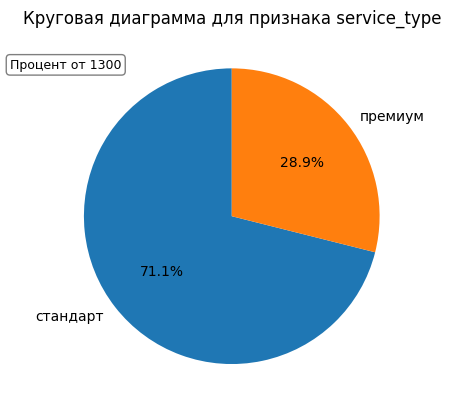

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


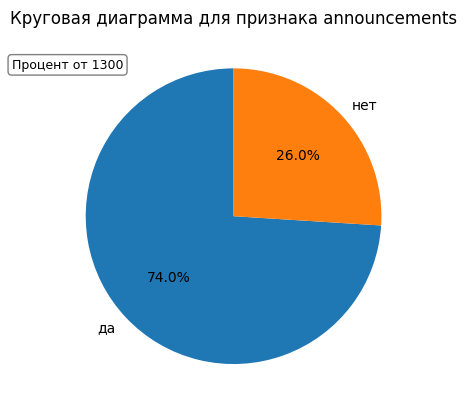

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


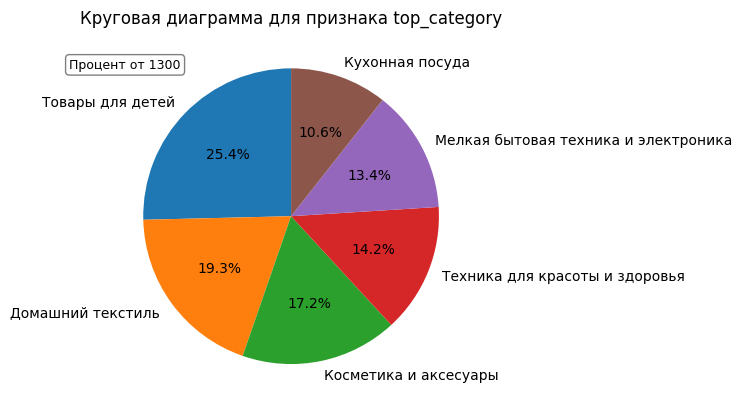

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


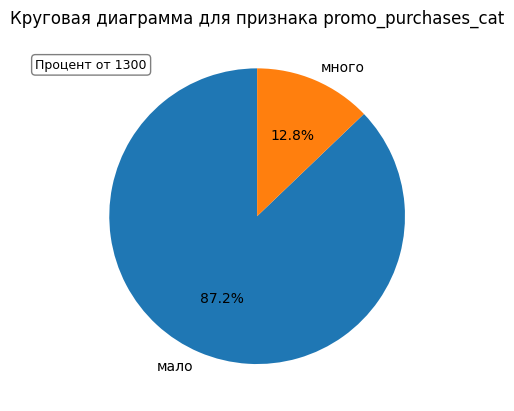

------------------------------------------------------------------------------------------


In [36]:
# вывод круговых диаграмм для всех категориальных признаков
for col in cat_features(market_file):
    piechart(market_file, col)

- В целевом признаке buying_activity наблюдается дисбаланс классов: у большинства клиентов (61.7%) покупательская активность осталась прежней.
- Входные признаки также распределены неравномерно:
    - Среди типа сервиса преобладает "стандарт" (71.1%)
    - Большинство пользователей допускают уведомления (74.0%)
    - У большинства пользователей (87.2%) мало акционных покупок, как было отмечено ранее на материале числового признака
    - Среди категорий товаров лидируют товары для детей (25.4%), а самая редкая категория -- кухонная посуда (10.6%)

### 3.3. Датафрейм market_money

In [37]:
# перевод id в индекс
market_money = market_money.set_index('id')

------------------------------------------------------------------------------------------
--- Границы выбросов: (2271.6, 7681.55)


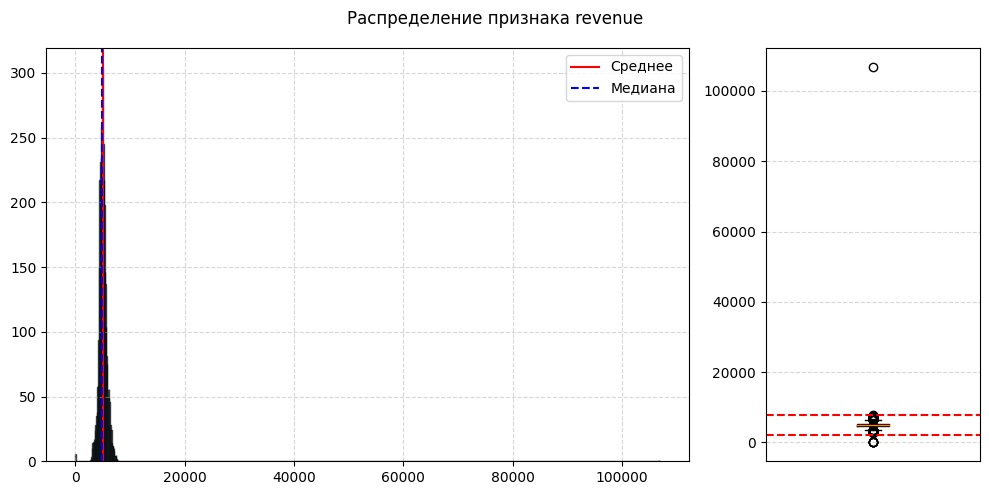

Описательные статистики для признака revenue:
count      3900.000
mean       5025.696
std        1777.704
min           0.000
25%        4590.150
50%        4957.500
75%        5363.000
max      106862.200
Name: revenue, dtype: float64
------------------------------------------------------------------------------------------


In [38]:
# вывод графиков и описательных статистик
for col in num_features(market_money):
    boxplot_histogram(market_money, col)

- В признаке revenue (выручка от клиента) обнаружены выбросы: нулевая выручка и высокое значение выручки, более чем в 10 раз превышающее типичные значения.

Посмотрим на графики с отфильтрованными выбросами:

------------------------------------------------------------------------------------------
--- Границы выбросов: (2278.8, 7676.15)


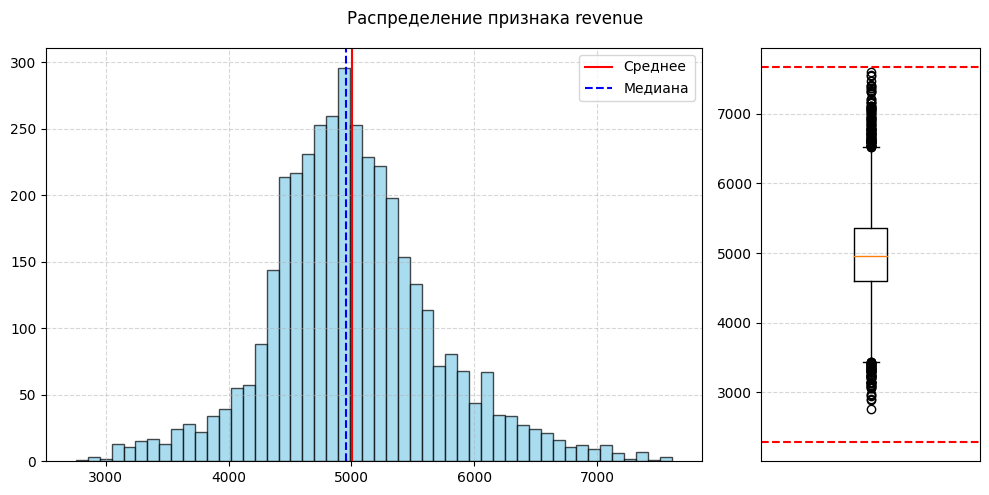

Описательные статистики для признака revenue:
count    3892.000
mean     5006.566
std       678.337
min      2758.700
25%      4591.950
50%      4959.000
75%      5363.000
max      7605.300
Name: revenue, dtype: float64
------------------------------------------------------------------------------------------
Исключено 8 значений (0.21% данных)


In [39]:
# вывод графиков и описательных статистик
boxplot_histogram(market_money[(market_money['revenue'] > 2271.6) & (market_money['revenue'] < 7681.55)], 'revenue')
n_excluded = market_money[(market_money['revenue'] <= 2271.6) | (market_money['revenue'] >= 7681.55)].shape[0]
prop_excluded = market_money[(market_money['revenue'] <= 2271.6) | (market_money['revenue'] >= 7681.55)].shape[0]/market_money.shape[0]
print(f'Исключено {n_excluded} значений ({prop_excluded:.2%} данных)')

- После фильтрации грубых выбросов распределение признака revenue нормальное, но оно имеет длинные хвосты. Заменим значения выше верхнего порога на медианное. Нулевые значения пока сохраним, так как они помогут отследить покупателей с покупательской способностью меньше 3 месяцев.

In [40]:
# замена выбросов медианой
market_money.loc[market_money['revenue'] >= 7681.55, 'revenue'] = market_money['revenue'].median()

------------------------------------------------------------------------------------------


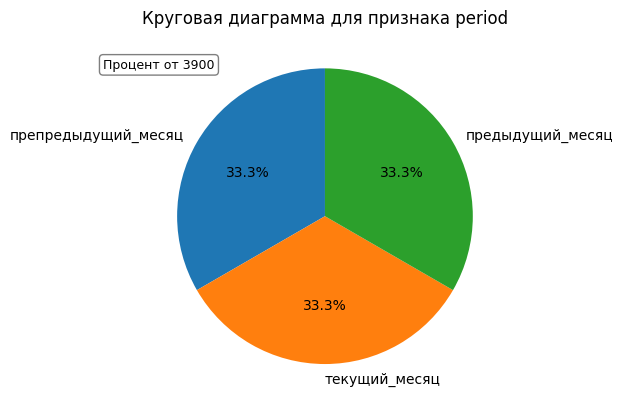

------------------------------------------------------------------------------------------


In [41]:
# вывод круговых диаграмм для всех категориальных признаков
for col in cat_features(market_money):
    piechart(market_money, col)

- Периоды в данных равномерно распеределены.

### 3.4. Датафрейм market_time

In [42]:
# перевод id в индекс
market_time = market_time.set_index('id')

------------------------------------------------------------------------------------------


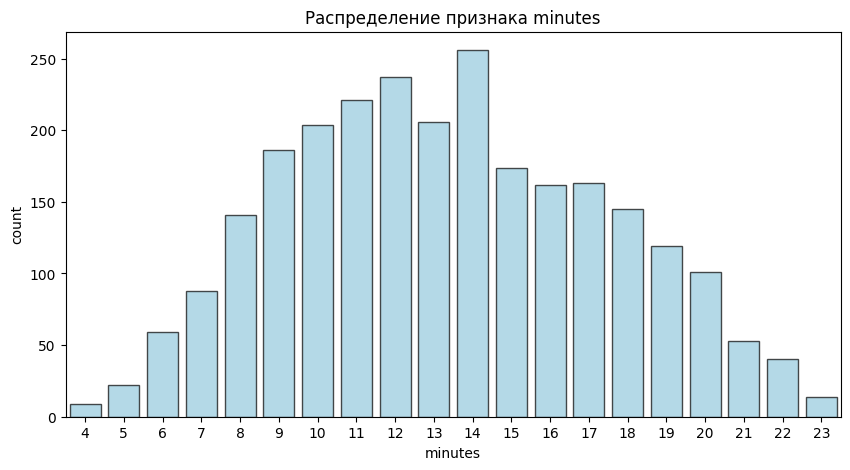

Описательные статистики для признака minutes:
count    2600.000
mean       13.336
std         4.080
min         4.000
25%        10.000
50%        13.000
75%        16.000
max        23.000
Name: minutes, dtype: float64
------------------------------------------------------------------------------------------


In [43]:
# вывод графиков и описательных статистик
for col in num_features(market_time):
    boxplot_histogram(market_time, col)

- Значения в признаке minutes распределены нормально.

------------------------------------------------------------------------------------------


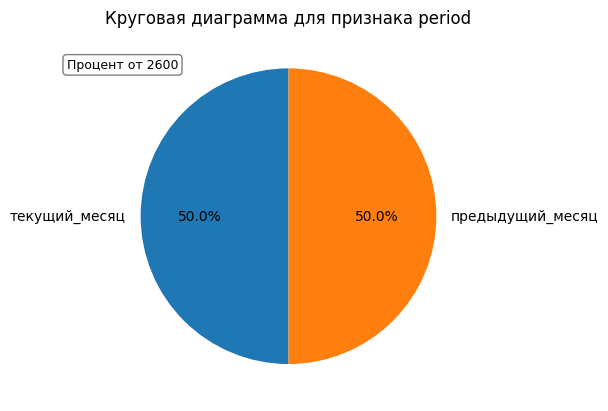

------------------------------------------------------------------------------------------


In [44]:
# вывод круговых диаграмм для всех категориальных признаков
for col in cat_features(market_time):
    piechart(market_time, col)

- Периоды в данных распределены равномерно.

### 3.5. Датафрейм money

In [45]:
# перевод id в индекс
money = money.set_index('id')

------------------------------------------------------------------------------------------
--- Граница выбросов 8.78


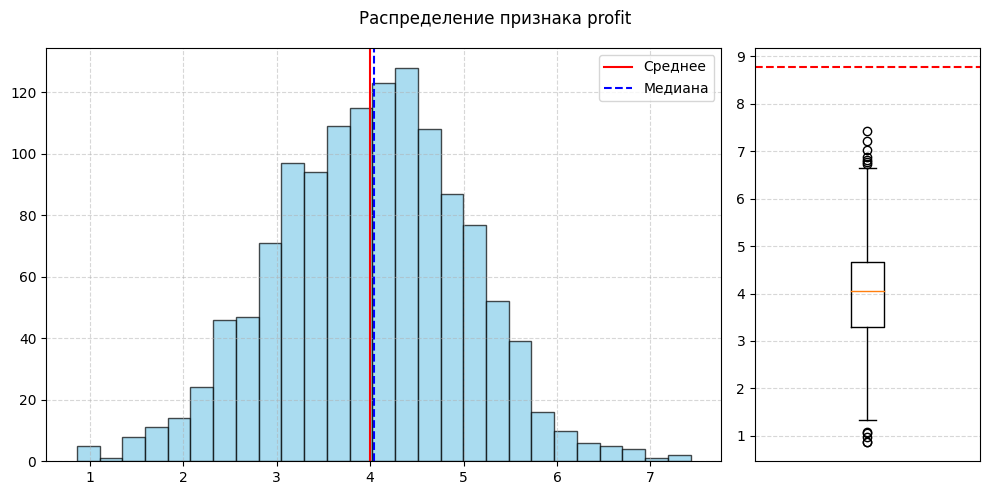

Описательные статистики для признака profit:
count    1300.000
mean        3.997
std         1.014
min         0.860
25%         3.300
50%         4.045
75%         4.670
max         7.430
Name: profit, dtype: float64
------------------------------------------------------------------------------------------


In [46]:
# вывод графиков и описательных статистик
for col in num_features(money):
    boxplot_histogram(money, col)

В признаке profit (прибыль) распределение нормальное, но у него длинные хвосты.

### 3.6. Отбор клиентов
Нам необходимо отобрать клиентов с покупательской активностью не менее трёх месяцев. Чтобы оценить наличие покупок в этот период, воспользуемся датасетом market_money.

In [47]:
# проверим наличие нулевой выручки от клиента
activity_3m = pd.DataFrame(market_money.groupby('id')['revenue'].agg([lambda x: (x == 0).any(), lambda x: x.min()]))
activity_3m.columns = ['any_zero_revenue', 'min_revenue']
activity_3m.head(10)

,any_zero_revenue,min_revenue
id,,
215348,True,0.0
215349,False,4472.0
215350,False,4826.0
215351,False,4793.0
215352,False,4594.0
215353,False,4738.5
215354,False,4503.0
215355,False,3263.0
215356,False,4146.5


In [48]:
# выделим релевантные id
print('Первые 10 строк датафрейма с данными о выручке от клиентов с покупательской активностью не менее 3 месяцев:')
print(activity_3m.query("any_zero_revenue == False").head(10))
relevant_ids = activity_3m.query("any_zero_revenue == False").index.tolist()
relevant_ids
print('Изначальное количество клиентов:', len(market_money.index.unique()))
print('Количество релевантных клиентов:', len(relevant_ids))

Первые 10 строк датафрейма с данными о выручке от клиентов с покупательской активностью не менее 3 месяцев:
        any_zero_revenue  min_revenue
id                                   
215349             False       4472.0
215350             False       4826.0
215351             False       4793.0
215352             False       4594.0
215353             False       4738.5
215354             False       4503.0
215355             False       3263.0
215356             False       4146.5
215358             False       3488.0
215360             False       5304.5
Изначальное количество клиентов: 1300
Количество релевантных клиентов: 1297


### 3.7. Выводы
- Мы провели графический анализ данных из 4 таблиц и вывели для количественных признаков описательные статистики.
- Некоторые количественные признаки распеределены ненормально или близко к нормальному (marketing_mean, marketing_current, duration, categories_per_visit, revenue, minutes, profit), некоторые нет (promo_purchases, unpaid_items, pages_for_visit).
- Чтобы сохранить высокие значения акционных покупок, мы создали категориальный признак promo_purchases_cat, в котором доля акционных покупок ниже 0.69 считается низкой, а выше этого значения -- высокой.
- В датафреймах market_file, market_time и money выбросов в данных не обнаружилось, а в датафрейме market_money обнаружились выбросы в области больших значений, которые мы заменили медианой, и нулевые значения, которые отсеклись на этапе отбора клиентов.
- Мы отобрали клиентов, которые совершали покупки в течение всех трех предыдущих месяцев (1297/1300 клиентов). На следующем этапе отфильтруем их из таблицы, которая будет использоваться для построения модели.
- Значения категориальных признаков в большинстве распеределены неравномерно. Наиболее важно, что в целевом признаке есть дисбаланс: среди значений покупательской активности 61.7% -- это 'прежний уровень', а 38.8% -- 'снизилась'. Это необходимо будет учесть на этапе моделирования.

## 4. Объединение таблиц 
Объединим таблицы market_file.csv, market_money.csv, market_time.csv. Предварительно переведем market_money и market_time в широкий формат, чтобы каждому периоду в данных соответствовал отдельный столбец.

In [49]:
# перевод в широкий формат
market_money_wide = market_money.pivot_table(index='id', columns='period', values='revenue').reset_index()
print(market_money_wide.isna().sum())
market_money_wide.columns = ['id', 'revenue_-1m', 'revenue_-2m', 'revenue_current']
market_money_wide = market_money_wide.set_index('id')
market_money_wide.head()

period
id                     0
предыдущий_месяц       0
препредыдущий_месяц    0
текущий_месяц          0
dtype: int64


,revenue_-1m,revenue_-2m,revenue_current
id,,,
215348,0.0,0.0,3293.1
215349,5216.0,4472.0,4971.6
215350,5457.5,4826.0,5058.4
215351,6158.0,4793.0,6610.4
215352,5807.5,4594.0,5872.5


In [50]:
# перевод в широкий формат
market_time_wide = market_time.pivot_table(index='id', columns='period', values='minutes').reset_index()
print(market_time_wide.isna().sum())
market_time_wide.columns = ['id', 'minutes_-1m', 'minutes_current']
market_time_wide = market_time_wide.set_index('id')
market_time_wide.head()

period
id                  0
предыдущий_месяц    0
текущий_месяц       0
dtype: int64


,minutes_-1m,minutes_current
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


Формат данных изменен, столбцы названы корректно, пропусков не образовалось. Объединим market_file сначала с одним датафреймом, потом с другим, опираясь на id клиентов.

In [51]:
# объединение датафреймов
market_file = market_file.merge(market_money_wide, on='id', how='left')
market_file.head()

,buying_activity,service_type,announcements,marketing_mean,marketing_current,duration,promo_purchases,top_category,categories_per_visit,unpaid_items,errors,pages_per_visit,promo_purchases_cat,revenue_-1m,revenue_-2m,revenue_current
id,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,мало,0.0,0.0,3293.1
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,много,5216.0,4472.0,4971.6
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,мало,5457.5,4826.0,5058.4
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,много,6158.0,4793.0,6610.4
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,много,5807.5,4594.0,5872.5


In [52]:
# объединение датафреймов
market_file = market_file.merge(market_time_wide, on='id', how='left')
market_file.head()

,buying_activity,service_type,announcements,marketing_mean,marketing_current,duration,promo_purchases,top_category,categories_per_visit,unpaid_items,errors,pages_per_visit,promo_purchases_cat,revenue_-1m,revenue_-2m,revenue_current,minutes_-1m,minutes_current
id,,,,,,,,,,,,,,,,,,
215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,мало,0.0,0.0,3293.1,13,14
215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,много,5216.0,4472.0,4971.6,12,10
215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,мало,5457.5,4826.0,5058.4,8,13
215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,много,6158.0,4793.0,6610.4,11,13
215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,много,5807.5,4594.0,5872.5,8,11


Данные соотнесены. Осталось удалить нерелевантных клиентов (с покупательской активностью меньше 3 месяцев). Воспользуемся списком id, который создали ранее.

In [53]:
# сохраним только релевантных клиентов
print('Изначальная длина датафрейма market_file:', market_file.shape[0])
market_file = market_file[market_file.index.isin(relevant_ids)]
print('Итоговая длина датафрейма market_file:', market_file.shape[0])

Изначальная длина датафрейма market_file: 1300
Итоговая длина датафрейма market_file: 1297


## 5. Корреляционный анализ
Для проверки корреляций между признаками в количественной шкале в итоговой таблице построим матрицу корреляций:

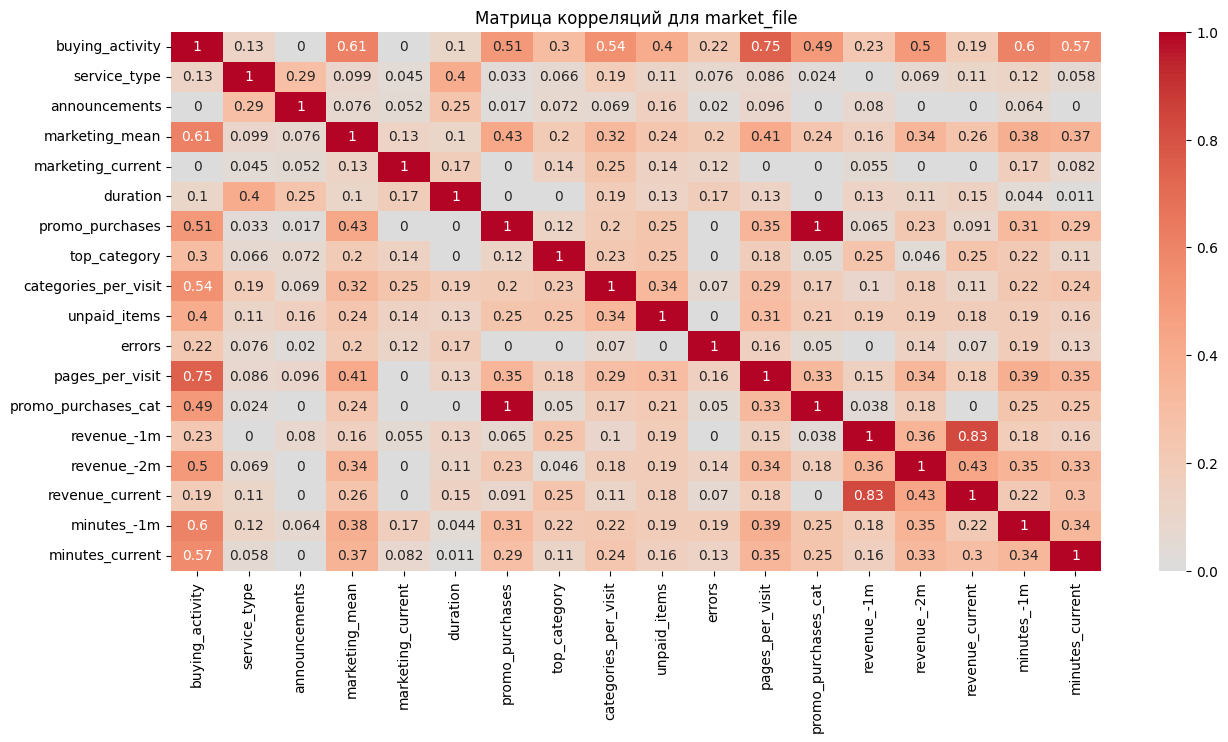

In [54]:
# матрица корреляций
plt.figure(figsize=(15,7))
plt.title('Матрица корреляций для market_file')
sns.heatmap(market_file[features(market_file)].phik_matrix(interval_cols=['market_mean',
                                                                          'duration',
                                                                          'promo_purchases',
                                                                          'revenue_-2m',
                                                                          'revenue_-1m',
                                                                          'revenue_current']),
             cmap='coolwarm', center=0, annot=True
           )
plt.show()

### Выводы
- С целевым признаком (buying_activity) сильнее всего коррелируют:
    - Среднее количество страниц за визит (pages_per_visit)
    - Среднее число маркетинговых коммуникаций (marketing_mean)
    - Количество минут на сайте в прошлом и текущем месяце (minutes_-1m, minutes_current)
    - Среднее количество категорий за визит (categories_per_visit)
    - Доля акционных покупок (promo_purchases)
    - Выручка за препредыдущий месяц (revenue_-2m)
- Между входными признаками не обнаружено сильных корреляций (кроме как между двумя признаками-аналогами -- promo_purchases и promo_purchases_cat), поэтому удалять ничего не будем, но в моделировании будем использовать только promo_purchases_cat.

## 6. Использование пайплайнов
Чтобы спрогнозировать снижение покупательской активности, построим пайплайн для выбора лучшей модели классификации с оптимальными параметрами.

In [55]:
# задаем константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

Из набора входных признаков для модели исключим promo_purchases, вместо него используем promo_purchases_cat.

In [56]:
# выделение входных и целевого признаков
X = market_file.drop(['buying_activity', 'promo_purchases'], axis=1)
y = market_file['buying_activity']
X.columns.tolist()

['service_type',
 'announcements',
 'marketing_mean',
 'marketing_current',
 'duration',
 'top_category',
 'categories_per_visit',
 'unpaid_items',
 'errors',
 'pages_per_visit',
 'promo_purchases_cat',
 'revenue_-1m',
 'revenue_-2m',
 'revenue_current',
 'minutes_-1m',
 'minutes_current']

Будем предсказывать снижение покупательской активности на основании:
- типа сервиса,
- наличия разрешения на уведомления,
- количества маркетинговых коммуникаций (среднемесячного и в текущем месяце),
- длительности пребывания на сайте,
- популярной категории товара,
- среднего количества категорий за визит,
- общего количества неоплаченных товаров за 3 месяца,
- количества сбоев на сайте,
- среднего количества страниц за визит,
- категории по количеству акционных покупок (мало, много),
- выручки с клиента за 3 месяца,
- времени на сайте за предыдущий и текущий месяц

Разделим данные на тренировочную и тестовую выборки. Поскольку целевой класс не сбалансирован, будем использовать стратификацию.

In [57]:
# разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE,
    stratify = y)

print('Размер тренировочной выборки', X_train.shape)
print('Размер тестовой выборки', X_test.shape)

Размер тренировочной выборки (972, 16)
Размер тестовой выборки (325, 16)


Данные корректно разделены.

Разделим категориальные и количественные признаки для дальнейшей раздельной обработки.

In [58]:
# списки с названиями категориальных и количественных признаков
ohe_columns = ['top_category']
ord_columns = ['announcements', 'service_type', 'promo_purchases_cat']
num_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print('Неупорядоченные категориальные признаки:')
print(ohe_columns)
print('Упорядоченные категориальные признаки:')
print(ord_columns)
print('Количественные признаки:')
num_columns

Неупорядоченные категориальные признаки:
['top_category']
Упорядоченные категориальные признаки:
['announcements', 'service_type', 'promo_purchases_cat']
Количественные признаки:


['marketing_mean',
 'marketing_current',
 'duration',
 'categories_per_visit',
 'unpaid_items',
 'errors',
 'pages_per_visit',
 'revenue_-1m',
 'revenue_-2m',
 'revenue_current',
 'minutes_-1m',
 'minutes_current']

Создадим пайплайн для раздельной подготовки категориальных и количественных данных.

In [59]:
# пайплайна для подготовки неупорядоченных и упорядоченных категориальных признаков
# SimpleImputer + OneHotEncoder для неупорядоченных
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

# SimpleImputer + OrdinalEncoder для упорядоченных
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan,
                             categories=[['нет', 'да'],
                                         ['стандарт', 'премиум'],
                                         ['мало', 'много']])),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [60]:
# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

- Создадим общий пайплайн, который при помощи RandomizedSearch выберет лучшую модель из четырех классификаторов (KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, SVC) и подберет для нее оптимальные гиперпараметры.

- Для категориальных признаков на этапе предобработки будем использовать два кодировщика: OneHotEncoder для неупорядоченных признаков и OrdinalEncoder для упорядоченных. Для количественных на этапе масштабирования будем выбирать между StandardScaler, MinMaxScaler и RobustScaler. Переберем некоторые варианты гиперпараметров для моделей:
    - Для DecisionTreeClassifier: глубину дерева и максимальное число признаков для разбиения
    - Для KNeighborsClassifier: количество соседей
    - Для LogisticRegression: сила регуляризации
    - Для SVC: сила регуляризации<br><br>

- Для логистической регрессии укажем регуляризацию l2, чтобы избежать переобучения.
- Проведем кросс-валидацию на 5 блоках.
- Для тренировочной выборки подсчитаем метрику ROC-AUC. В нашей задаче преимущественно важно верно определить как можно большее количество экземпляров целевого признака, но также полезно будет ошибочно не приписывать класс 'снизилась', чтобы затем направить ресурсы на удержание клиентов, относительно которых действительно есть риск. ROC-AUC подходит для такой задачи, так как одновременно оценивает true positive rate и false positive rate. Более того, она хорошо работает для несбалансированного целевого признака.

In [61]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,5),
        'models__max_features': range(2,5),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']
    },
    
    # словарь для модели KNeighborsClassifier() 
    #{
    #    'models': [KNeighborsClassifier()],
    #    'models__n_neighbors': range(3, 15, 3),
    #    'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
    #},

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l2'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']  
    },
    
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, kernel='linear', probability=True)],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), RobustScaler(), 'passthrough']  
    }
]

In [62]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации:', randomized_search.best_score_.round(4))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['top_category']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                   

Лучшей моделью оказалась логистическая регрессия с силой регуляризации l2 C=2, и обработкой количественных признаков при помощи RobustScaler.

Предскажем снижение покупательской активности на тестовой выборке:

In [63]:
# предсказание вероятностей и расчет метрики ROC AUC
y_test_pred = randomized_search.predict_proba(X_test)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred).round(4)}')

Метрика ROC-AUC на тестовой выборке: 0.9224


Выведем график кривой ROC-AUC:

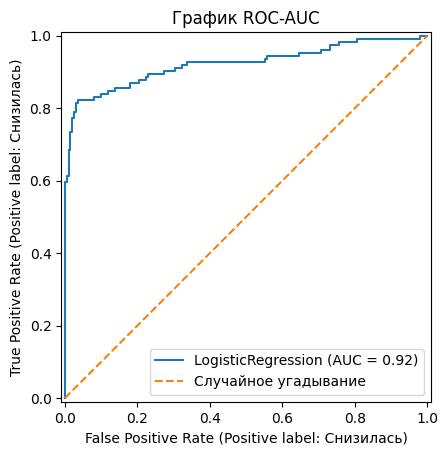

In [64]:
RocCurveDisplay.from_estimator(randomized_search.best_estimator_.named_steps['models'],
                               randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test),
                               y_test)
plt.plot([0,1], [0,1], linestyle='dashed', label='Случайное угадывание')
plt.title("График ROC-AUC")
plt.legend()
plt.show()

### 6.1. Выводы
- Построенный пайплайн при помощи RandomizedSearch определил лучшую модель: логистическая регрессия с регуляризацией l2 силы C=4, и обработкой количественных признаков при помощи MinMaxScaler.
- Метрика на кросс-валидации и на тестовой выборке была высокой: ROC-AUC=0.90 и ROC-AUC=0.92.

## 7. Важность признаков
Оценим важность признаков при помощи графика SHAP.

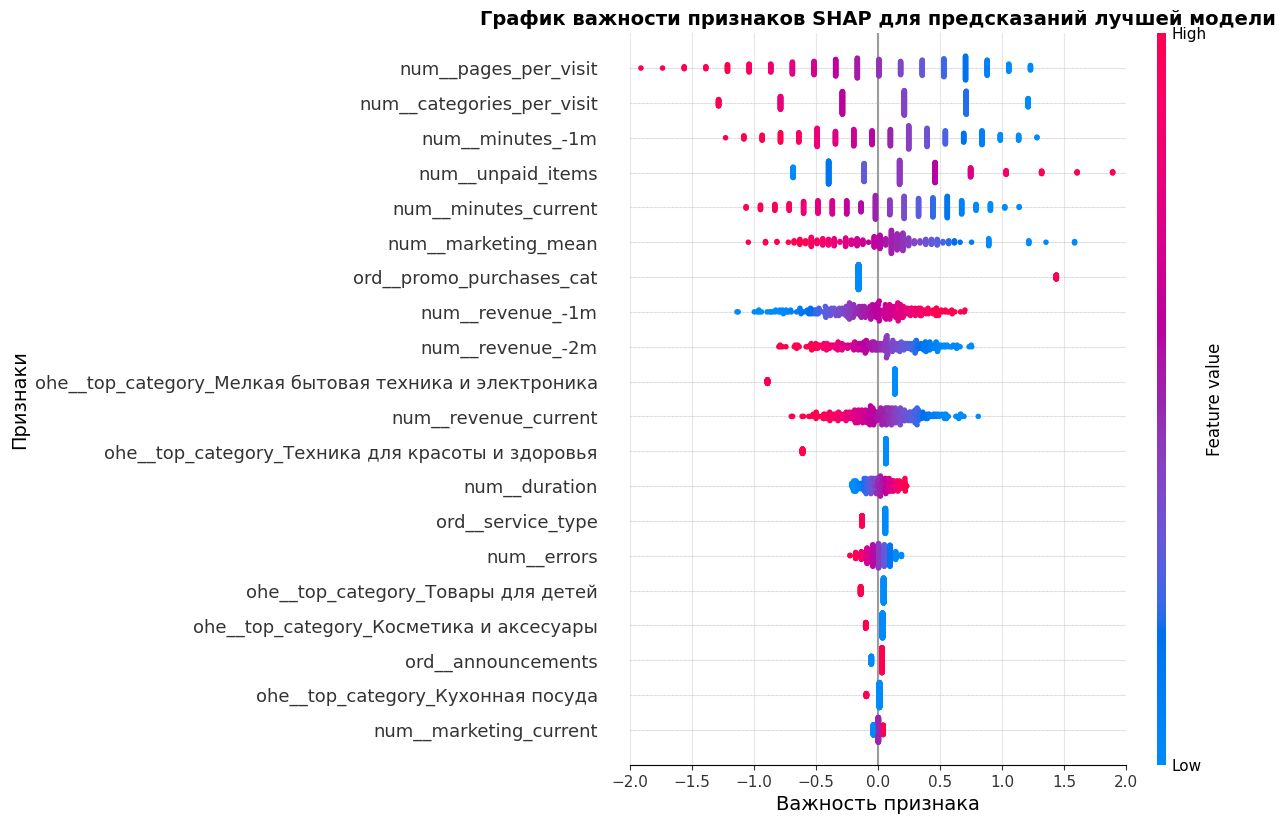

In [65]:
# построение графика SHAP
preprocessor = randomized_search.best_estimator_.named_steps['preprocessor']
model = randomized_search.best_estimator_.named_steps['models']

X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

features_list = preprocessor.get_feature_names_out()
#features_list = [s.replace("ohe__top_category_", "") for s in features_list]

explainer = shap.LinearExplainer(model, X_train_transformed, feature_names=features_list)
shap_values = explainer(X_test_transformed)

plt.figure(figsize=(100, 9))
shap.plots.beeswarm(shap_values, max_display=20, show=False)

plt.title('График важности признаков SHAP для предсказаний лучшей модели', fontweight='bold', fontsize=14)
plt.xlabel('Важность признака', fontsize=14)
plt.ylabel('Признаки', fontsize=14)
plt.xlim(-2,2)
plt.grid(True, alpha=0.3)
plt.show()

### 7.1. Выводы
**Наиболее важными для предсказания оказались следующие признаки:**
- Среднее количество страниц за визит (чем больше, тем **менее** вероятно снижение покупательской активности)
- Среднее количество категорий за визит (чем больше, тем **менее** вероятно снижение покупательской активности)
- Время на сайте за предыдущий месяц (чем больше, тем **менее** вероятно снижение покупательской активности)
- Количество неоплаченных товаров в корзине за последние три месяца (чем больше, тем **более** вероятно снижение покупательской активности)
- Время на сайте за текущий месяц (чем больше, тем **менее** вероятно снижение покупательской активности)
- Среднемесячное количество маркетинговых коммуникаций за полгода (чем больше, тем **менее** вероятно снижение покупательской активности)
- Доля акционных покупок (чем больше, тем **более** вероятно снижение покупательской активности)

**Наименее важными оказались:**
- Являются ли кухонная посуда или косметика и аксессуары наиболее популярной категорией
- Количество маркетинговых коммуникаций в текущем месяце

**Что из этого можно извлечь:**
- Наиболее важные признаки связаны с продуктовым поведением клиента, поэтому для удержания клиентов следует направить ресурсы на то, чтобы влиять на него.
- Также влияет количество среднее количество маркетинговых коммуникаций. Важно отметить, что, по-видимому, долгосрочная стратегия маркетинговой коммуникации имеет больше вес, чем точечные действия, поскольку маркетинговые коммуникации в текущем месяце (marketing_current) почти не повлияли на предсказание, а среднемесячное количество за полгода (marketing_mean) существенно повлияло на него.
- Акционные покупки -- важный маркер возможного снижения покупательской активности в будущем. Это следует учитывать при планировании акций.

## 8. Сегментация пользователей
### 8.1. Выбор сегмента

Рассмотрим группу клиентов с высокой вероятностью снижения покупательской активности и наиболее высокой прибыльностью, поскольку их потеря может существенно повлиять на компанию. Будем проводить анализ на тестовой выборке. Сначала создадим датафрейм, в который добавим столбец с предсказаниями:

In [66]:
# создаем датафрейм
client_segmenting = X_test
client_segmenting['decline_prob'] = randomized_search.predict_proba(X_test)[:,1]
client_segmenting.head()

,service_type,announcements,marketing_mean,marketing_current,duration,top_category,categories_per_visit,unpaid_items,errors,pages_per_visit,promo_purchases_cat,revenue_-1m,revenue_-2m,revenue_current,minutes_-1m,minutes_current,decline_prob
id,,,,,,,,,,,,,,,,,
216446,стандарт,да,5.3,5,433,Техника для красоты и здоровья,1,1,0,7,много,4712.0,5160.0,5230.7,15,20,0.377540
215469,премиум,да,4.1,3,813,Домашний текстиль,3,3,4,5,мало,5403.5,4889.0,5228.0,12,8,0.779148
216301,премиум,да,3.9,5,410,Косметика и аксесуары,3,1,5,14,мало,5052.5,5348.0,4926.4,17,13,0.049593
215713,стандарт,да,4.6,5,293,Товары для детей,1,3,3,3,мало,4821.0,4872.0,5221.4,12,14,0.781568
215500,стандарт,да,3.5,4,573,Косметика и аксесуары,2,4,1,4,мало,4137.0,4278.0,3808.1,11,12,0.939053


Также добавим в датафрейм данные о прибыльности клиента.

In [67]:
# объединение датафреймов
client_segmenting = client_segmenting.merge(money, how='left', on='id')
client_segmenting.head()

,service_type,announcements,marketing_mean,marketing_current,duration,top_category,categories_per_visit,unpaid_items,errors,pages_per_visit,promo_purchases_cat,revenue_-1m,revenue_-2m,revenue_current,minutes_-1m,minutes_current,decline_prob,profit
id,,,,,,,,,,,,,,,,,,
216446,стандарт,да,5.3,5,433,Техника для красоты и здоровья,1,1,0,7,много,4712.0,5160.0,5230.7,15,20,0.377540,4.47
215469,премиум,да,4.1,3,813,Домашний текстиль,3,3,4,5,мало,5403.5,4889.0,5228.0,12,8,0.779148,3.76
216301,премиум,да,3.9,5,410,Косметика и аксесуары,3,1,5,14,мало,5052.5,5348.0,4926.4,17,13,0.049593,4.34
215713,стандарт,да,4.6,5,293,Товары для детей,1,3,3,3,мало,4821.0,4872.0,5221.4,12,14,0.781568,4.42
215500,стандарт,да,3.5,4,573,Косметика и аксесуары,2,4,1,4,мало,4137.0,4278.0,3808.1,11,12,0.939053,4.99


Теперь графически изучим выборку и посмотрим, какой сегмент клиентов можно рассмотривать как клиентов с высокой вероятностью снижения покупательской активности и высокой прибыльностью.

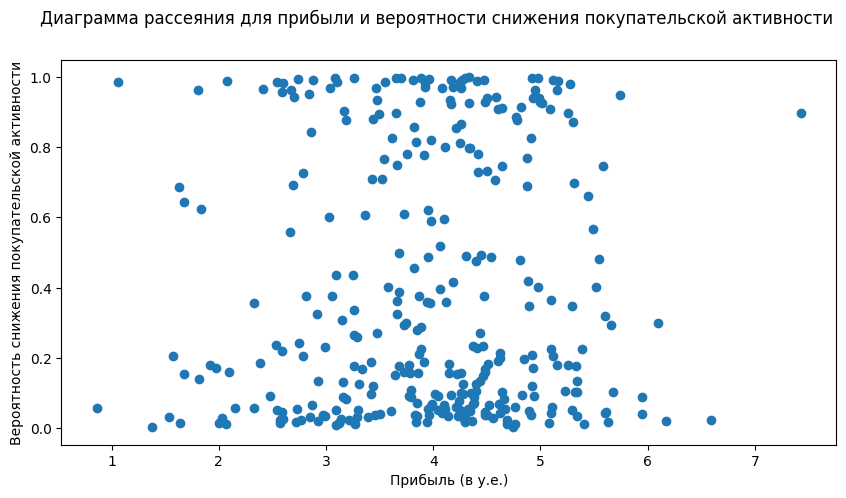

In [68]:
plt.figure(figsize=(10, 5)) 
plt.scatter(client_segmenting['profit'], client_segmenting['decline_prob'])
plt.suptitle('Диаграмма рассеяния для прибыли и вероятности снижения покупательской активности')
plt.xlabel('Прибыль (в у.е.)')
plt.ylabel('Вероятность снижения покупательской активности')
plt.show()

Попробуем выделить сегмент с вероятностью снижения покупательской активности > 0.65 и прибылью >= 4.

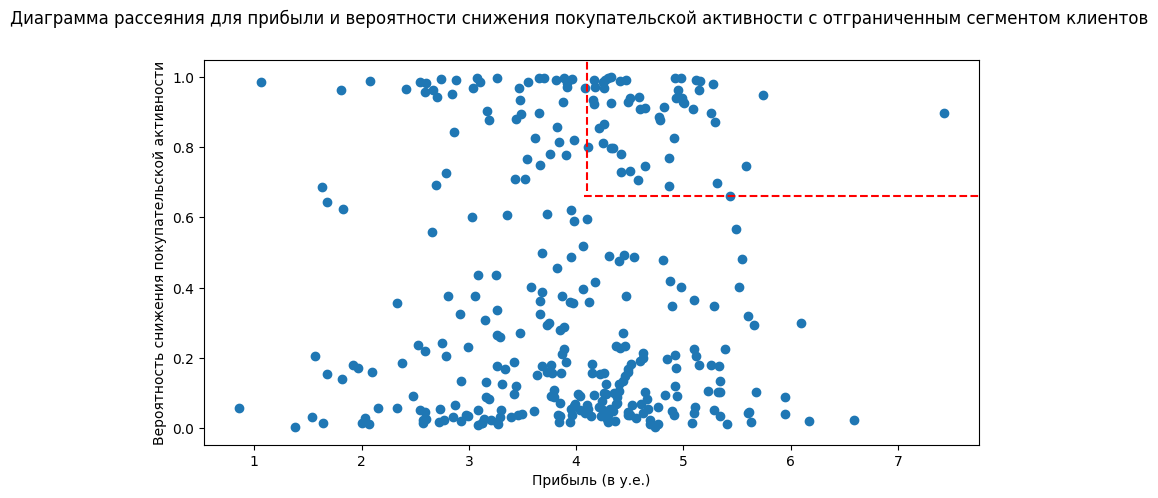

In [69]:
plt.figure(figsize=(10, 5)) 
plt.scatter(client_segmenting['profit'], client_segmenting['decline_prob'])
plt.suptitle('Диаграмма рассеяния для прибыли и вероятности снижения покупательской активности с отграниченным сегментом клиентов')
plt.xlabel('Прибыль (в у.е.)')
plt.ylabel('Вероятность снижения покупательской активности')
plt.axvline(x=4.1, color='red', linestyle='--', ymin=0.66)
plt.axhline(y=0.66, color='red', linestyle='--', xmin=0.49)
plt.show()

Выделим сегмент:

In [70]:
segment = client_segmenting[(client_segmenting['profit'] >= 4) & (client_segmenting['decline_prob'] > 0.65)]
segment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54 entries, 215713 to 215398
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   service_type          54 non-null     object 
 1   announcements         54 non-null     object 
 2   marketing_mean        54 non-null     float64
 3   marketing_current     54 non-null     int64  
 4   duration              54 non-null     int64  
 5   top_category          54 non-null     object 
 6   categories_per_visit  54 non-null     int64  
 7   unpaid_items          54 non-null     int64  
 8   errors                54 non-null     int64  
 9   pages_per_visit       54 non-null     int64  
 10  promo_purchases_cat   54 non-null     object 
 11  revenue_-1m           54 non-null     float64
 12  revenue_-2m           54 non-null     float64
 13  revenue_current       54 non-null     float64
 14  minutes_-1m           54 non-null     int64  
 15  minutes_current 

В нашей выборке 53 клиента. Изучим их характеристики.

### 8.2. Изучение сегмента

#### Категориальные признаки 

Выведем круговые диаграммы для категориальных признаков:

------------------------------------------------------------------------------------------


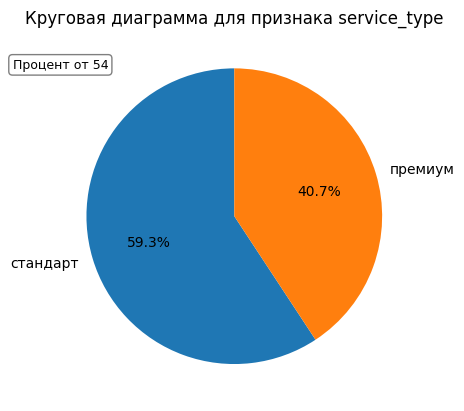

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


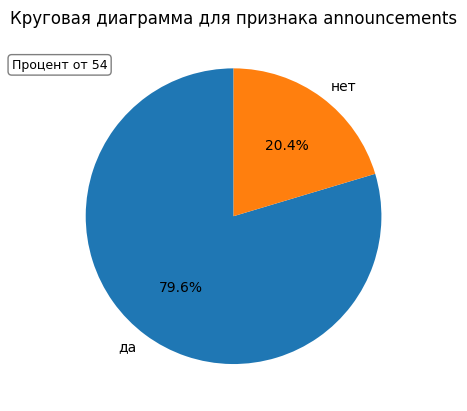

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


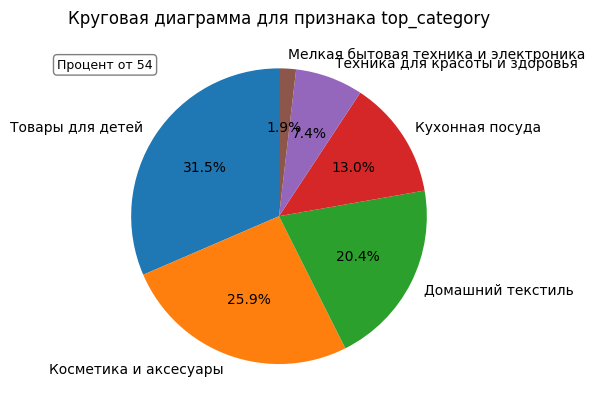

------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


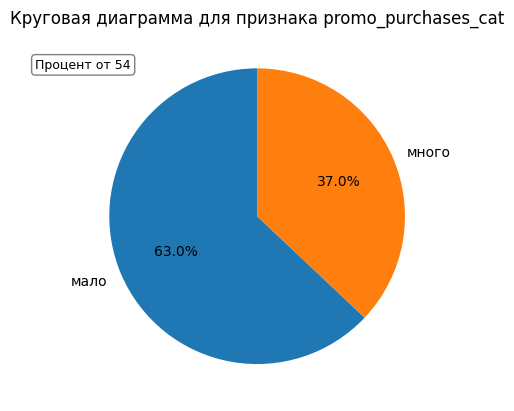

------------------------------------------------------------------------------------------


In [71]:
# круговые диаграммы
for col in cat_features(segment):
    piechart(segment, col)

#### Количественные признаки

Выведем гистограммы и диаграммы размаха для количественных признаков.

------------------------------------------------------------------------------------------


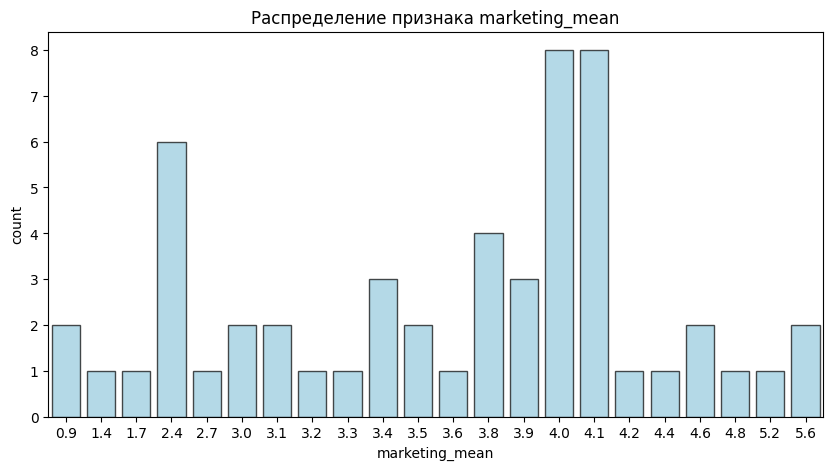

Описательные статистики для признака marketing_mean:
count    54.000
mean      3.559
std       0.997
min       0.900
25%       3.100
50%       3.850
75%       4.100
max       5.600
Name: marketing_mean, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


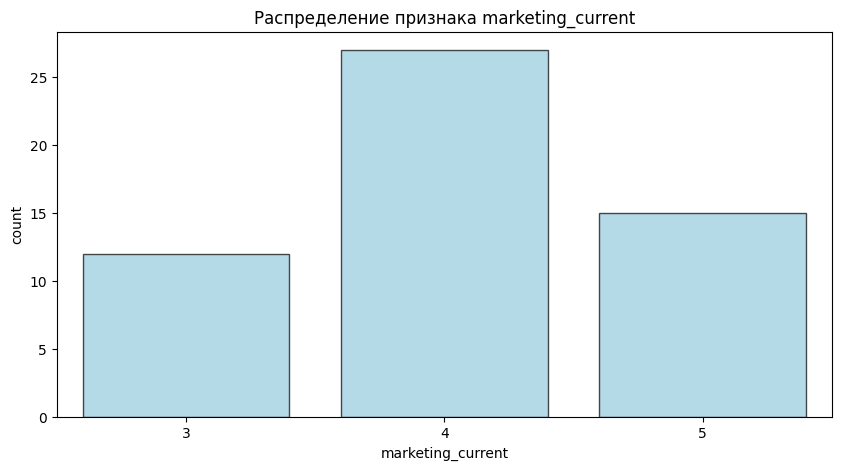

Описательные статистики для признака marketing_current:
count    54.000
mean      4.056
std       0.712
min       3.000
25%       4.000
50%       4.000
75%       5.000
max       5.000
Name: marketing_current, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
--- Граница выбросов 1884.75


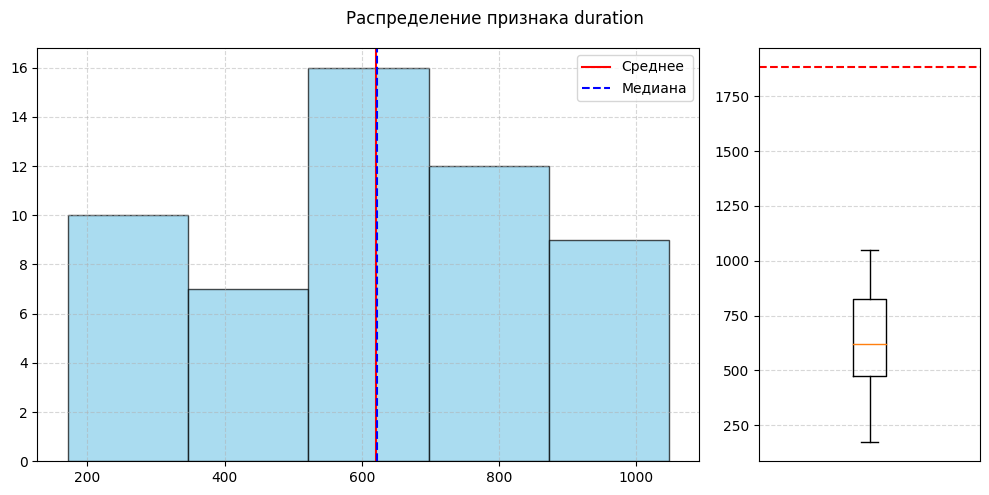

Описательные статистики для признака duration:
count      54.000
mean      619.907
std       237.173
min       171.000
25%       473.750
50%       622.500
75%       826.500
max      1048.000
Name: duration, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


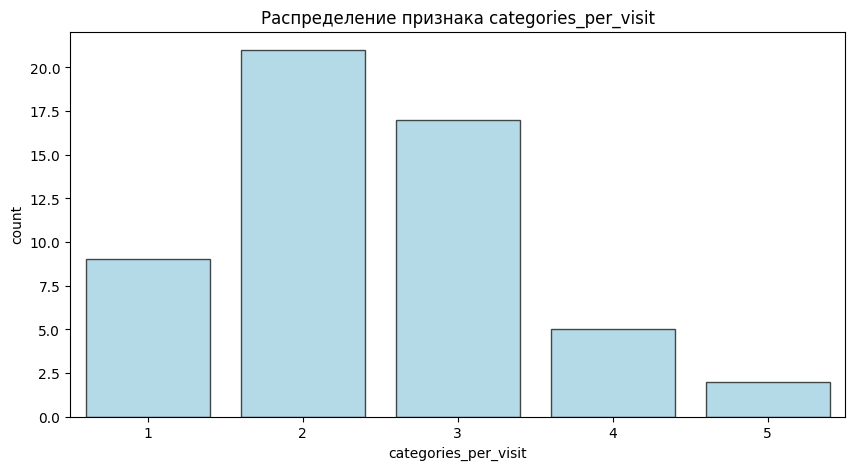

Описательные статистики для признака categories_per_visit:
count    54.000
mean      2.444
std       1.003
min       1.000
25%       2.000
50%       2.000
75%       3.000
max       5.000
Name: categories_per_visit, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


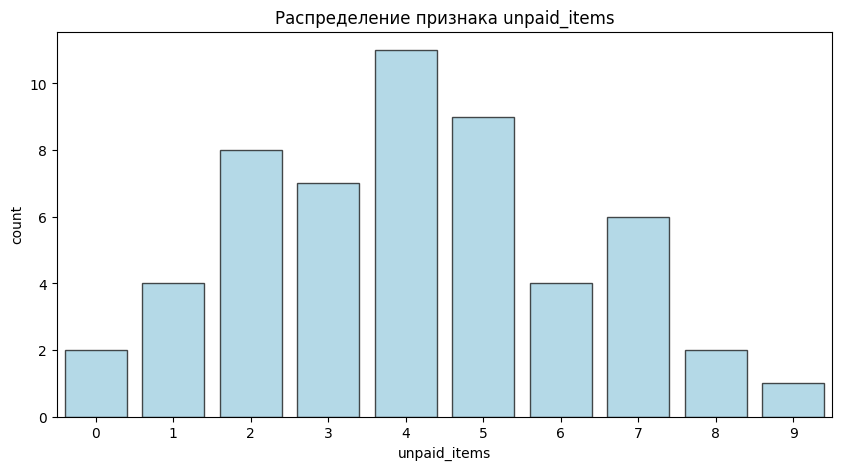

Описательные статистики для признака unpaid_items:
count    54.000
mean      4.093
std       2.139
min       0.000
25%       2.250
50%       4.000
75%       5.000
max       9.000
Name: unpaid_items, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


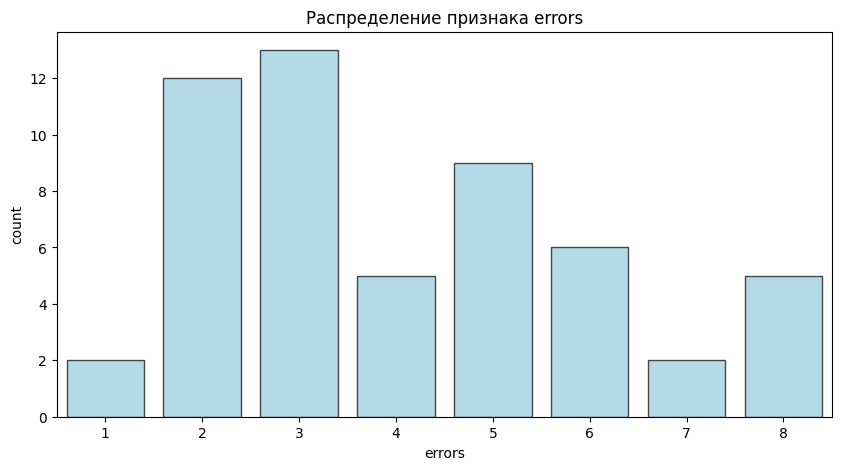

Описательные статистики для признака errors:
count    54.000
mean      4.074
std       1.989
min       1.000
25%       2.250
50%       3.500
75%       5.000
max       8.000
Name: errors, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


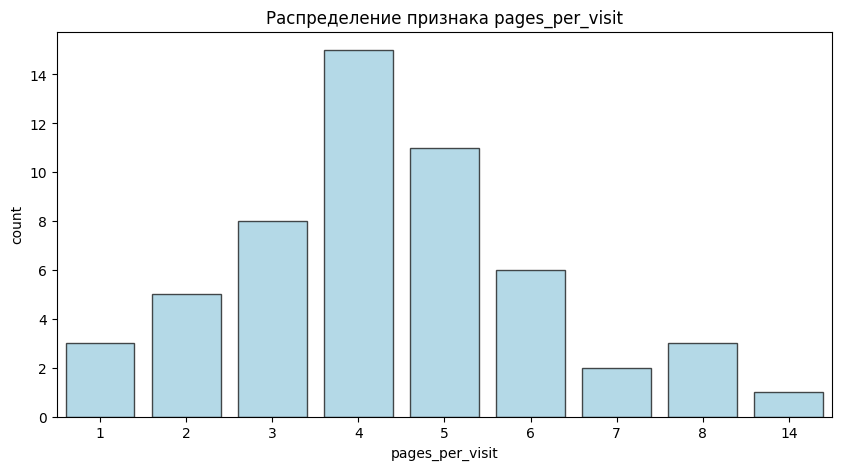

Описательные статистики для признака pages_per_visit:
count    54.000
mean      4.444
std       2.151
min       1.000
25%       3.000
50%       4.000
75%       5.000
max      14.000
Name: pages_per_visit, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
--- Границы выбросов: (1936.0, 8250.0)


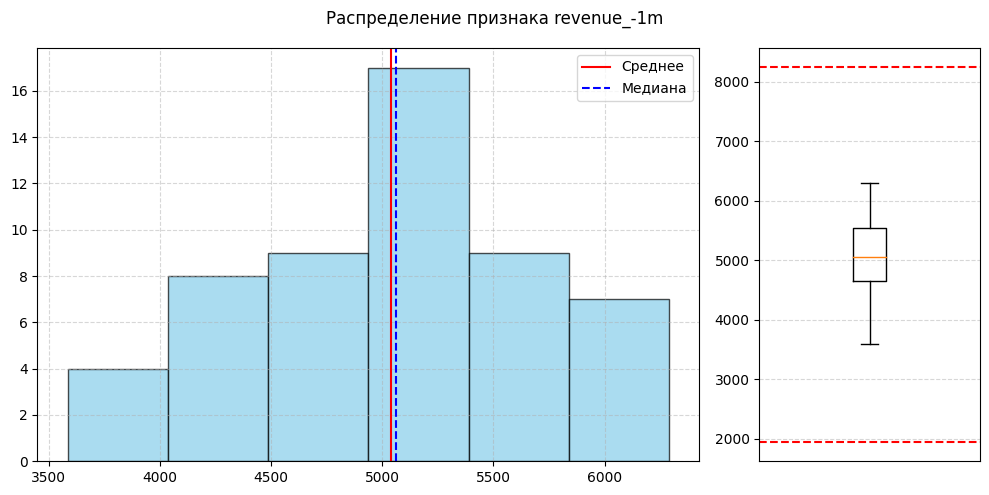

Описательные статистики для признака revenue_-1m:
count      54.000
mean     5041.287
std       673.282
min      3584.000
25%      4642.000
50%      5060.500
75%      5544.000
max      6291.500
Name: revenue_-1m, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
--- Границы выбросов: (3509.75, 5762.0)


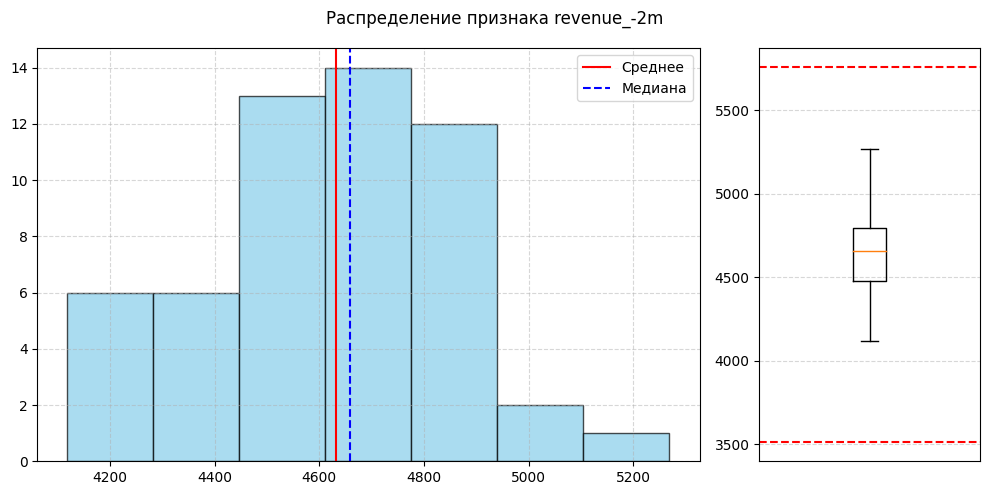

Описательные статистики для признака revenue_-2m:
count      54.000
mean     4631.870
std       238.211
min      4119.000
25%      4475.000
50%      4659.500
75%      4796.750
max      5269.000
Name: revenue_-2m, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------
--- Границы выбросов: (805.375, 10138.3)


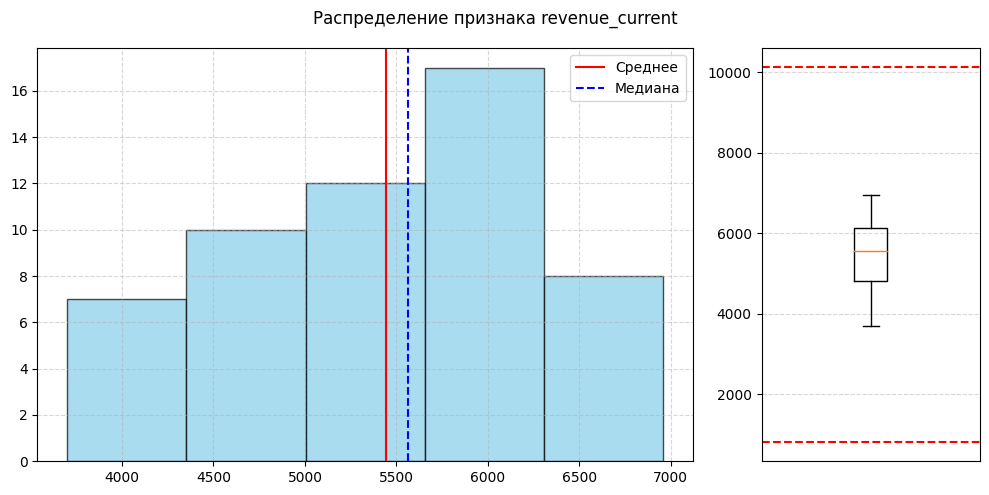

Описательные статистики для признака revenue_current:
count      54.000
mean     5442.819
std       865.820
min      3700.700
25%      4805.200
50%      5561.900
75%      6138.475
max      6957.700
Name: revenue_current, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


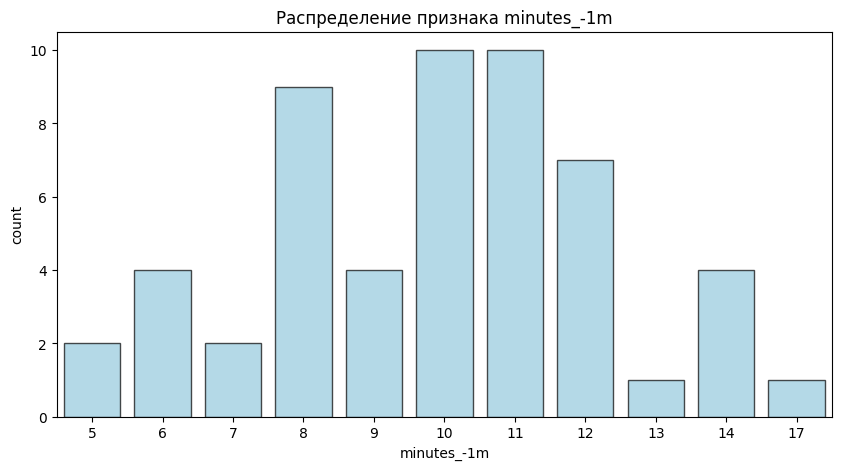

Описательные статистики для признака minutes_-1m:
count    54.000
mean      9.926
std       2.502
min       5.000
25%       8.000
50%      10.000
75%      11.000
max      17.000
Name: minutes_-1m, dtype: float64
------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------


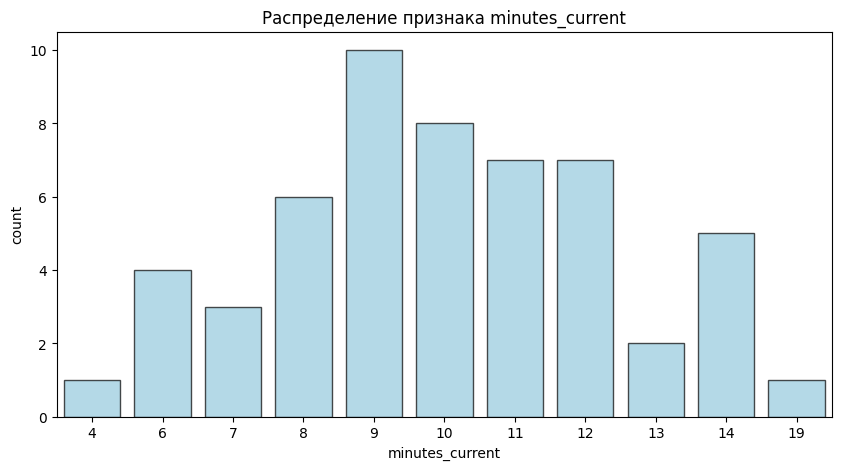

Описательные статистики для признака minutes_current:
count    54.000
mean     10.056
std       2.659
min       4.000
25%       8.250
50%      10.000
75%      12.000
max      19.000
Name: minutes_current, dtype: float64
------------------------------------------------------------------------------------------


In [72]:
segment_numcols = num_features(segment)
segment_numcols = segment_numcols[:-2]
for col in segment_numcols:
    boxplot_histogram(segment, col)

### 8.3. Выводы
**Особенности сегмента:**
У сегмента клиентов с высокой прибыльностью и высокой вероятностью снижения покупательской активности есть такие особенности:
- В сегменте существенная часть премиум-клиентов (60.4%)
- Среди популярных категории товаров "Техника для красоты и здоровья" и  "Мелкая техника и электроника" наименее представлены, в то время как было показано, что популярность этих категорий в некоторой мере влияет на покупательскую активность (чем популярнее категория -- тем меньше вероятность снижения покупательской активности).
- В этом сегменте более существенная, чем в общей выборке, доля людей, часто совершающих акционные покупки (37.7%). Это может влиять на покупательскую активность группы (была показана достаточно существенная важность этого признака в модели).
- Распределение количества неоплаченных товаров в корзине за период отличается от распределения по всей выборке в сторону большего количества неоплаченных товаров. Этот признак существенно влияет на покупательскую активность.
- Существенная разница обнаружилась в среднем количестве страниц за визит (в среднем 4.4 против 8.2 по всей выборке). Это наиболее важный признак, влияющий на покупательскую активность.
- Выручка в препредыдущем месяце в сегменте существенно ниже, чем по всей выборке (4631 против 5007 у.е.). Этот признак достаточно сильно влияет на покупательскую активность.
- Количество минут на сайте за предыдущий и текущей месяцы в сегменте немного меньше, чем по всей выборке (в среднем 10 против 13.3). Эти признаки сильно влияют на покупательскую активность.

Таким образом, внутри выбранного сегмента по продуктовому поведению покупателей и по выручке можно действительно предположить, что их покупательская активность снизится (на основании того, что показал анализ важности признаков). Это также может указывает на то, на что можно направить ресурсы для удержания этого сегмента клиентов.

**Рекомендации:**
- Наиболее существенные особенности клиентов в сегменте качаются взаимодействия с сайтом: они просматривают меньше страниц и категорий и в целом проводят меньше времени на сайте. Поскольку большая часть клиентов дала согласие на рассылку, а также существенная часть клиентов имеет премиум-подписку, можно предложить в рассылках или в контенте для подписчиков распространять подборки товаров различных категорий, чтобы стимулировать взаимодействие с сайтом. Кроме того, полезно сделать упор на рекомендации товаров внутри сайта, чтобы клиенты могли смотреть на похожие товары и глубже изучать сайт.
- Также может быть полезно делать рассылку с напоминанием о товарах в корзине, чтобы попробовать конвертировать их в покупки (большое количество неоплаченных товаров в корзине влияет на покупательскую активность).
- Вероятно, к акциям как к стимуляции покупательской активности следует относиться осторожно, учитывая категорию клиентов: например, клиенты, которые совершают преимущественно акционные покупки, с большей вероятностью становятся менее активными спустя время.

## 9. Общий вывод
- Перед нами стояла задача построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца, а затем, используя данные модели и дополнительные данные финансового департамента о прибыльности клиентов, выделить сегмент покупателей и разработать для него персонализированные предложения. Нам было предоставлено 4 таблицы:
    1. market_file.csv -- данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.
    2. market_money.csv -- данные о выручке, которую получил магазин с покупателя за период его взаимодействия с сайтом.
    3. market_time.csv -- данные о времени (в минутах), которое покупатель провёл на сайте в течение периода.
    4. money.csv -- данные о среднемесячной прибыли от покупателя за последние 3 месяца.<br><br>

- В ходе предобработки данных мы привели к стандарту названия столбцов, проверили наличие полных дубликатов и пропусков (их не обнаружилось) и исправили неявные дубликаты.

- Затем был проведен исследовательский анализ данных, в ходе которого были обработаны выбросы в значениях выручки и сохранены только те покупатели, у которых покупательская активность составляла не менее 3 месяцев (для дальнейшей работы были взяты данные 1297/1300 клиентов).

- Исследовательский анализ также показал дисбаланс классов в целевом признаке buying_activity (покупательская активность): 67.7% в классе 'прежний уровень' против 38.3% в классе 'снизилась'.

- Для поиска лучшей модели использовался пайплайн с алгоритмом RandomizedSearch. Мы перебрали несколько типов масштабирования количественных признаков (StandardScaler, MinMaxScaler, RobustScaler). Сравнивались 3 модели классификации: DecisionTreeClassifier, LogisticRegression и SVC, для каждой из которых перебирались гиперпараметры.

- Лучшей моделью оказалась логистическая регрессия со следующими параметрами:
    - Обработка количественных признаков с помощью RobustScaler
    - Параметр C для l2-регуляризации равный 2<br><br>

- В качестве метрики для оценки моделей использовалась ROC-AUC, которая лучше всего подходит для моделей классификации в условиях дисбаланса классов. Модель показала высокие результаты: ROC-AUC=0.90 на кросс-валидации и 0.92 на тестовой выборке.

**Результаты моделирования, выводы, рекомендации:**

- Анализ важности признаков показал, что наиболее важны для предсказания покупательской активности следующие признаки:
    - Среднее количество страниц за визит (чем больше, тем менее вероятно снижение покупательской активности)
    - Среднее количество категорий за визит (чем больше, тем менее вероятно снижение покупательской активности)
    - Время на сайте за предыдущий месяц (чем больше, тем менее вероятно снижение покупательской активности)
    - Количество неоплаченных товаров в корзине за последние три месяца (чем больше, тем более вероятно снижение покупательской активности)
    - Время на сайте за текущий месяц (чем больше, тем менее вероятно снижение покупательской активности)
    - Среднемесячное количество маркетинговых коммуникаций за полгода (чем больше, тем менее вероятно снижение покупательской активности)
    - Доля акционных покупок (чем больше, тем более вероятно снижение покупательской активности)<br><br>

- То есть, для удержания клиента полезно влиять на его продуктовое поведение: стимулировать взаимодействие с сайтом.

- При этом полезна регулярность маркетинговых коммуникаций.

- Акционные покупки -- важный маркер возможного снижения покупательской активности в будущем. Это следует учитывать при планировании акций.

- Мы рассмотрели категорию покупателей с высокой прибыльностью и высокой вероятностью снижения покупательской активности. Это важный сегмент, поскольку от его удержания зависит и дальнейшая прибыль магазина. Поскольку наиболее существенная особенность этого сегмента -- менее активное взаимодействие с сайтом, предлагается делать рассылки с подборками товаров и напоминать о неоплаченных товарах в корзине.